Imports & Setup

In [1]:
import os

# Processing Libs 
import PIL.Image as Image

# NN libs'
import torch 
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Neural Imaging Libs
import nibabel as nib
import nilearn as nl

#Getting helper scripts
from utils.data_loader import BraTSDatasetP1, BraTSDatasetP3, BraTSDatasetP2, get_brats_filepaths, build_cache, split_brats_dataset,patch_consistency_test
from utils.metrics import compare_pipelines_dice, DiceCELoss
from utils.unet import UNet3D, UNet3D_Optimized_2 #,UNet3D_Optimized_1

from utils.train_unet import run_experiment
from utils.seeding import set_global_seed
from utils.visualize import plot_losses_per_seed, plot_loss_summary, visualize_sample, visualize_patient_consistency, plot_model_comparison,visualize_prediction_multiview
from utils.run_train_eval import run_train_eval

In [3]:
# General Paths
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"

Loading and Visualizing sample data

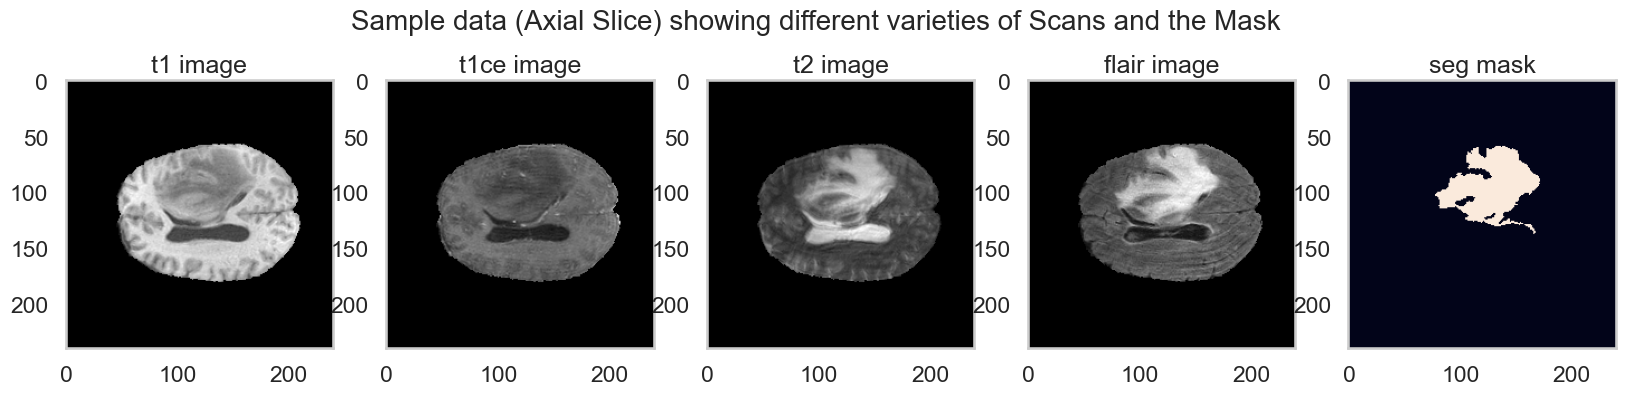

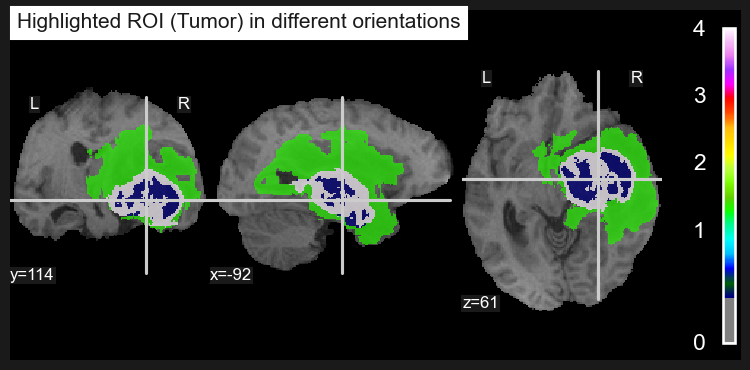

In [11]:
###
Test_filepath = "data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"
# Loading data and extracting image data with "get_fdata()"
test_t1_image = nib.load(Test_filepath + "BraTS20_Training_001_t1.nii").get_fdata()
test_t1ce_image = nib.load(Test_filepath + "BraTS20_Training_001_t1ce.nii").get_fdata()
test_t2_image = nib.load(Test_filepath + "BraTS20_Training_001_t2.nii").get_fdata()
test_flair_image = nib.load(Test_filepath + "BraTS20_Training_001_flair.nii").get_fdata()
test_mask = nib.load(Test_filepath + "BraTS20_Training_001_seg.nii").get_fdata()

volume_show = 89 #Orientation to view 

# Visualizing sample of Image data
visualize_sample(Test_filepath,test_t1_image,test_t1ce_image,test_t2_image,test_flair_image, test_mask, volume_show)


Dataset Preprocessing

In [6]:
#Extract image and mask paths
trainingData_root_dir = os.path.join(RAW_DATA_PATH, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData") #create directory to data
image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 
print(mask_paths[354]) #Test Print

data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_seg.nii


In [8]:
#  Performing Patientwise split 
train_imgs, val_imgs, train_masks, val_masks = split_brats_dataset(
    image_paths, mask_paths, val_size=0.2, seed=42
)

print(f"Train patients: {len(train_imgs)}")
print(f"Val patients: {len(val_imgs)}")

# Derive patient IDs from the split lists
def pid_from_modalities(modality_paths):
    """
    modality_paths: list of 4 paths [flair, t1, t1ce, t2]
    Returns the patient folder name used in cache (e.g., 'BraTS20_Training_001').
    """
    return os.path.basename(os.path.dirname(modality_paths[0]))

train_pids = [pid_from_modalities(m) for m in train_imgs] #Extracting train patient IDs
val_pids   = [pid_from_modalities(m) for m in val_imgs] #Extracting val patient IDs

# Checking if lengths match
len(train_pids) == len(train_imgs), len(val_pids)  == len(val_imgs)

Train patients: 295
Val patients: 74


(True, True)

DATA preprocessing --> ABLATION STUDIES

We evaluated three different preprocessing pipelines to investigate whether certain preprocessing shortcuts could speed up training without compromising data integrity. The goal was to test if cached volumes or pre-extracted patches (P2, P3) remain comparable to the standard on-the-fly preprocessing approach (P1) in terms of preserving anatomical structures and segmentation quality. These pipelines are built in data_loader.py file

In [11]:
'''
Preparing directories to create Cache (saved image patches and volumes) for P2 and P3 using the split
'''
# Cache directories
cache_root = "data/processed/cache"
cache_train = os.path.join(cache_root, "train")
cache_val   = os.path.join(cache_root, "val")

In [19]:
# # 
'''
Build cache for train and val separately (we execute once and comment out to prevent corrupting the data)

'''
# build_cache(train_imgs, train_masks, out_dir=cache_train, num_patches=8)  # P2 & P3 train
# build_cache(val_imgs, val_masks, out_dir=cache_val, num_patches=8)        # P2 & P3 val

Caching patients: 100%|██████████████████████████████████████████████████████| 295/295 [32:38<00:00,  6.64s/it]


Cache built at: data/processed/cache\train/volumes (P2) and data/processed/cache\train/patches (P3)


Caching patients: 100%|████████████████████████████████████████████████████████| 74/74 [08:52<00:00,  7.20s/it]

Cache built at: data/processed/cache\val/volumes (P2) and data/processed/cache\val/patches (P3)


In [13]:
'''
Creating datasets for each pipeline; P1, P2, P3

'''

# P1 (on the fly)
train_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=True)
val_dataset_P1   = BraTSDatasetP1(val_imgs,   val_masks,   augment=False)

# P2 (cached volumes)
train_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_train, "volumes"),
    patient_ids=train_pids,
    patch_size=(96,96,96),
    augment=True
)
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

# P3 (cached patches)
train_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_train, "patches"),
    patient_ids=train_pids,
    augment=True
)
val_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_val, "patches"),
    patient_ids=val_pids,
    augment=False
)

In [15]:
'''
Quantitative Sanity checks:
Creating consistency check datasets (with augmentation --> off = False) for each pipeline; P1, P2, P3
And calculating Dice Scores to ensure the same patches are obtained for each pipeline (P1 vs P2, P1 vs P3, P2 vs P3) 

'''
# Instantiate all three datasets with augment=False
consistencyCheck_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=False) # P1 (on the fly)
consistencyCheck_dataset_P2 = BraTSDatasetP2(cache_dir=os.path.join(cache_train, "volumes"),patient_ids=train_pids,augment=False)# P2 (cached volumes)
consistencyCheck_dataset_P3 = BraTSDatasetP3(cache_dir=os.path.join(cache_train, "patches"),patient_ids=train_pids,augment=False)# P3 (cached patches)

# Pick a handful of patient indices to test
indices_to_test = [9, 0, 10]

res12 = patch_consistency_test(consistencyCheck_dataset_P1, consistencyCheck_dataset_P2, indices_to_test)
res13 = patch_consistency_test(consistencyCheck_dataset_P1, consistencyCheck_dataset_P3, indices_to_test)
res23 = patch_consistency_test(consistencyCheck_dataset_P2, consistencyCheck_dataset_P3, indices_to_test)

# Check minimum Dice across all tests
min12 = np.min(res12['per_class_dice'])
min13 = np.min(res13['per_class_dice'])
min23 = np.min(res23['per_class_dice'])

print(f"Minimum patch-Dice (P1 vs P2): {min12:.4f}")
print(f"Minimum patch-Dice (P1 vs P3): {min13:.4f}")
print(f"Minimum patch-Dice (P2 vs P3): {min23:.4f}")

Minimum patch-Dice (P1 vs P2): 1.0000
Minimum patch-Dice (P1 vs P3): 0.0000
Minimum patch-Dice (P2 vs P3): 0.0000


Plot saved to results/images/Patient_random-89_consistency.png


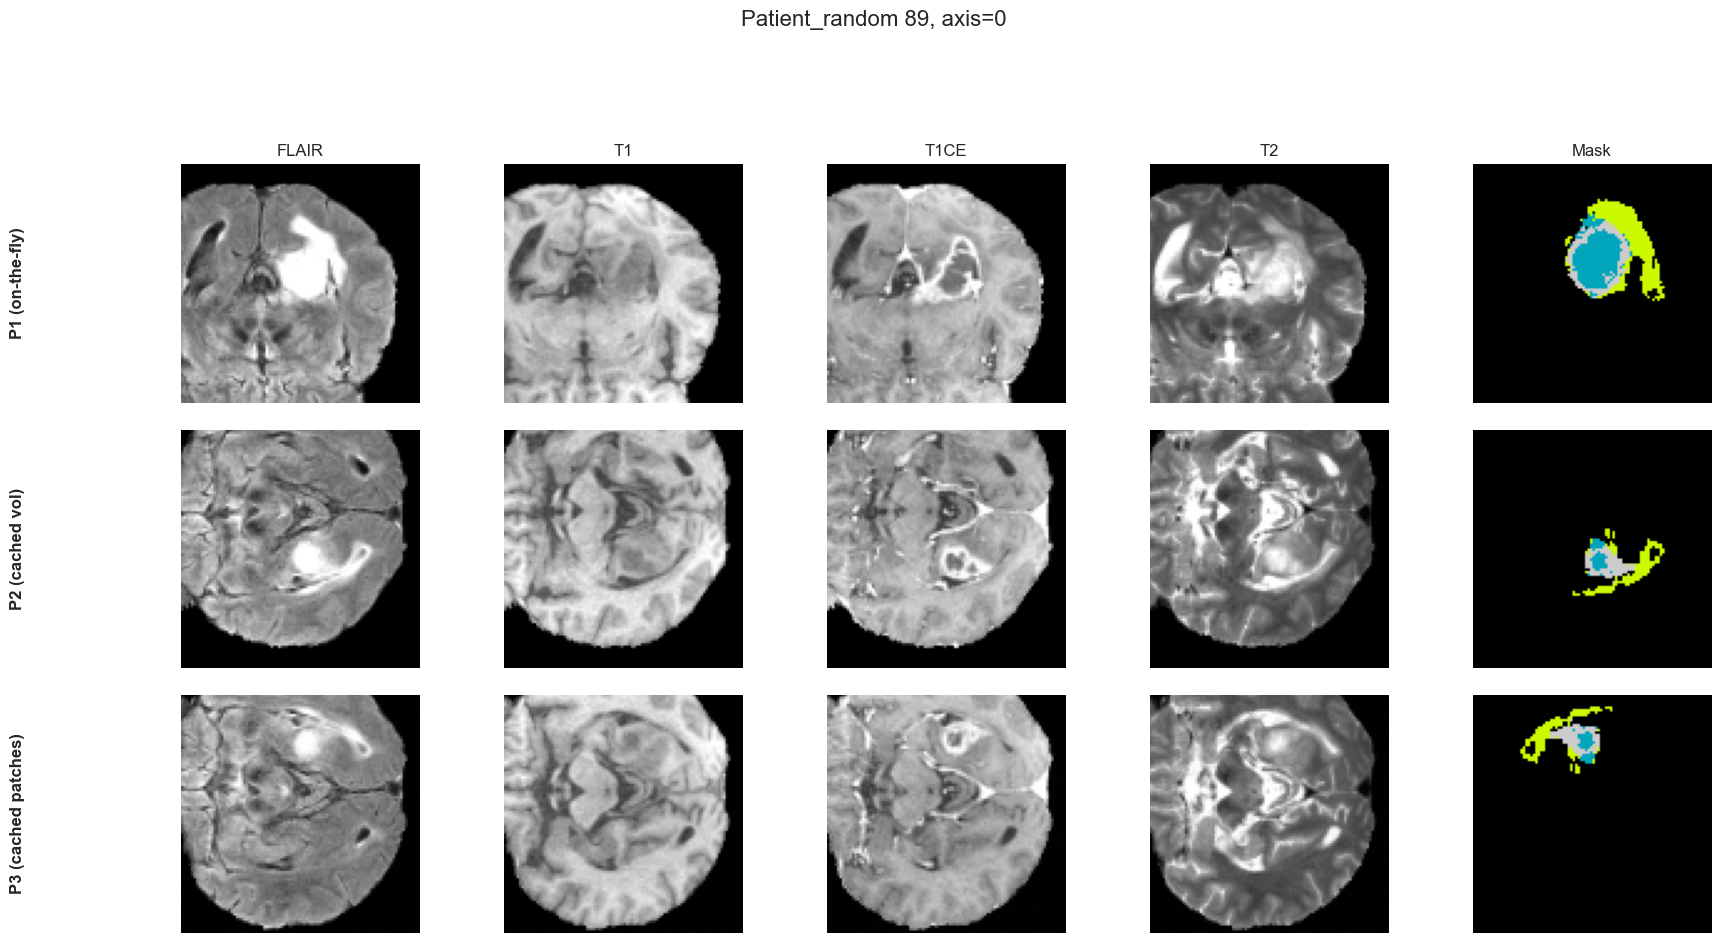

Plot saved to results/images/Patient_deterministic-89_consistency.png


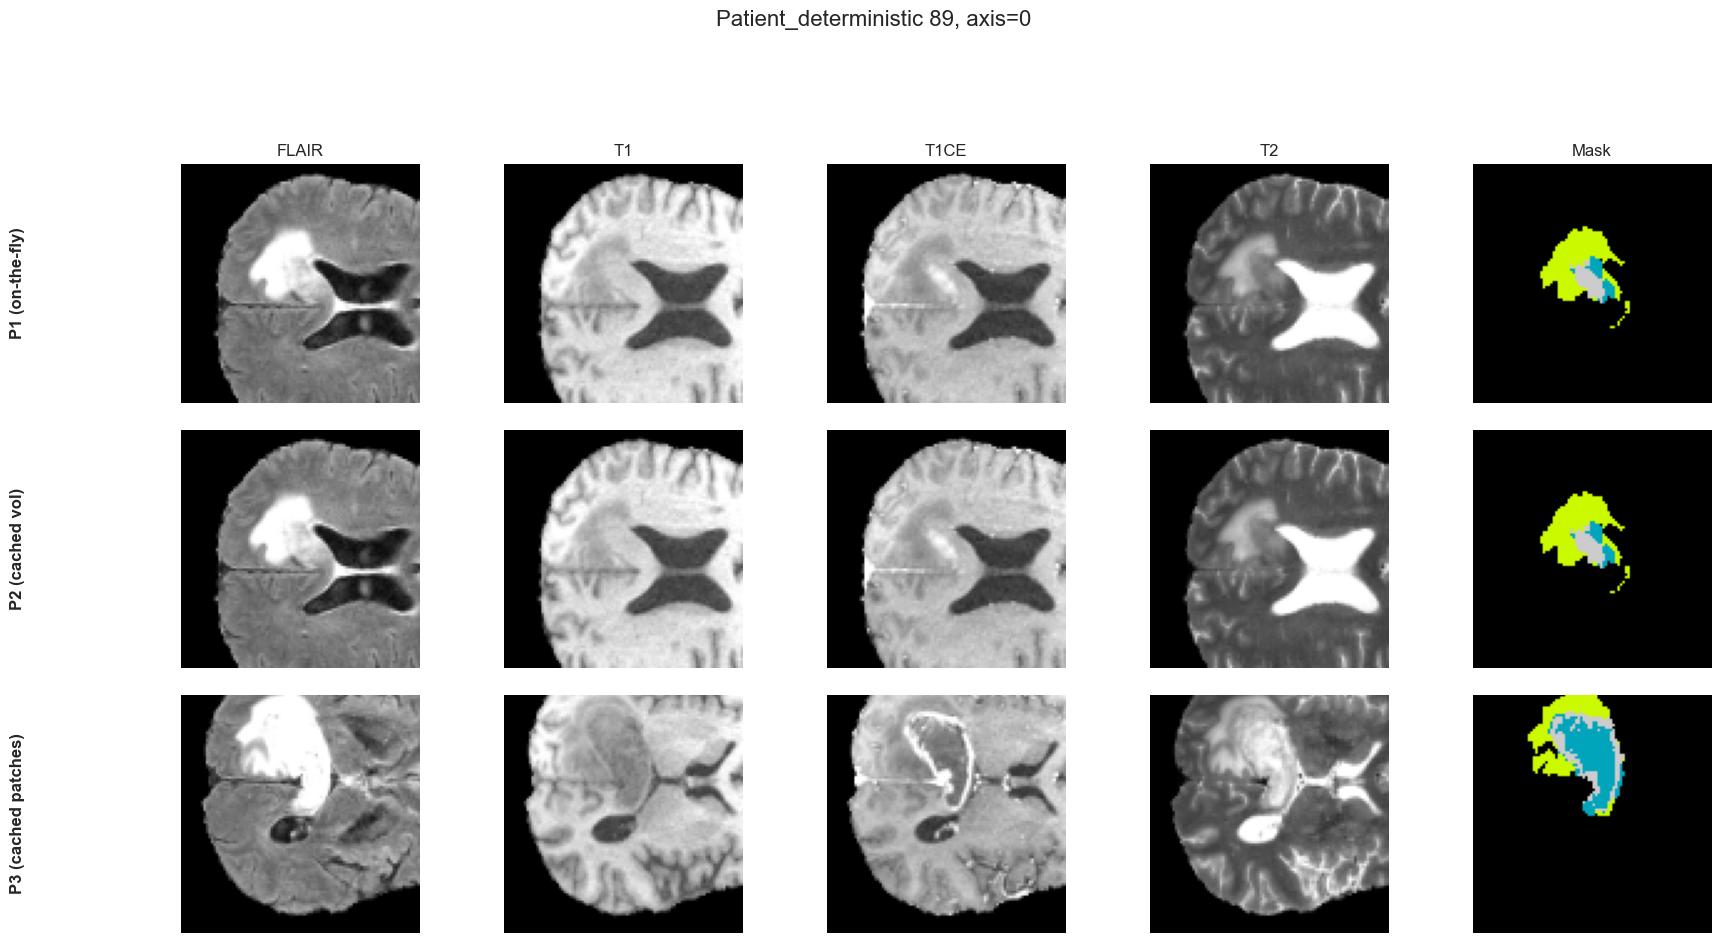

In [16]:
'''
Qualitative Sanity checks: 
Visualizing patches produced by the 3 pipelines -> mainly Checking for consistency of anatomical regions ("what the model sees!")
and integrity of data deterministically (seeded + no augmentations)
'''
#What the model really sees after all pipelines have been executed successfully (random patches)
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=89, seed = None)

#Seeded patch selection with No Augmentations just for sanity check of anatomical regions (Deterministic patches) 
visualize_patient_consistency(consistencyCheck_dataset_P1, consistencyCheck_dataset_P2, consistencyCheck_dataset_P3, patient_idx=89)

DataLoaders!

In [24]:
batch_size = 1
num_workers = 4
'''
Preparing data for both training and validation (for all three pipelines : P1, P2, P3)
"run this before training"
#commented p1/p3 out afer pipeline ablation : p2 wins

'''
#  DataLoaders
# DataLoaders
# train_loader_P1 = DataLoader(
#     train_dataset_P1, batch_size=batch_size, shuffle=True,
#     num_workers=num_workers, pin_memory=True
# )
# val_loader_P1 = DataLoader(
#     val_dataset_P1, batch_size=batch_size, shuffle=False,
#     num_workers=num_workers, pin_memory=True
# )

train_loader_P2 = DataLoader(
    train_dataset_P2, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True
)
val_loader_P2 = DataLoader(
    val_dataset_P2, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

# train_loader_P3 = DataLoader(
#     train_dataset_P3, batch_size=batch_size, shuffle=True,
#     num_workers=num_workers, pin_memory=True
# )
# val_loader_P3 = DataLoader(
#     val_dataset_P3, batch_size=batch_size, shuffle=False,
#     num_workers=num_workers, pin_memory=True
    
# )


def train_loader_printout(train_loader):
    for img, mask in train_loader:
        print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
        print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
        break


# Fetch a batch (example print)
# train_loader_printout(train_loader_P1), train_loader_printout(train_loader_P2), train_loader_printout(train_loader_P3)
train_loader_printout(train_loader_P2)

Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])


Experiments: Running the different pipelines through our Baseline U-Net Setup and Evaluating P1, P2, P3

In [25]:
###Pipeline Experiment: Please do not rerun(results below)

'''
run_experiment() trains the UNET on the pipelines (P1, P2, P3).
and evaluates the checkpoints obtained for P1, P2, P3.
'''

# # --- CONFIG ---
# epochs   = 30          # smoke test = 1, full ablation = 30
# patience = 10         # full ablation = 10
# lr       = 1e-4
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # seeds for reproducibility
# seeds = [0, 1, 2]   # smoke test = [42], full ablation = [0,1,2]

# pipelines = {
#     "P1": (train_loader_P1, val_loader_P1),
#     "P2": (train_loader_P2, val_loader_P2),
#     "P3": (train_loader_P3, val_loader_P3)
# }

# all_results   = {name: [] for name in pipelines}
# all_histories = []

# for seed in seeds:
#     print(f"\n=== Running experiments with seed {seed} ===")
#     set_global_seed(seed)

#     for name, (train_loader, val_loader) in pipelines.items():
#         print(f"\n--- Pipeline {name} ---")
#         model     = UNet3D(in_ch=4, out_ch=4).to(device)
#         loss_fn   = DiceCELoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer,
#             mode="min",     # minimize val loss
#             factor=0.5,     # reduce LR by half
#             patience=5,     # wait 5 epochs without improvement
#             min_lr=1e-6     # don’t go too small
#         )

#         # 1) Train and get history dict
#         ckpt, hist, total_time, avg_epoch_time, peak_mem = run_experiment(
#             model, optimizer, loss_fn,
#             train_loader, val_loader,
#             f"{name}_s{seed}", device,
#             epochs, lr, patience,
#             scheduler=scheduler, early_stopping=True
#         )

#         # 2) Save per-epoch history (with per-class cols)
#         n_epochs = len(hist["train_loss"])
#         df_hist = pd.DataFrame({
#             "seed":               [seed] * n_epochs,
#             "pipeline":           [name] * n_epochs,
#             "epoch":              list(range(1, n_epochs + 1)),
#             "train_loss":         hist["train_loss"],
#             "val_loss":           hist["val_loss"],
#             "val_dice":           hist["val_dice"],
#             "dice_bg":            [v[0] for v in hist["val_dice_per_class"]],
#             "dice_non_enh":       [v[1] for v in hist["val_dice_per_class"]],
#             "dice_edema":         [v[2] for v in hist["val_dice_per_class"]],
#             "dice_enhancing":     [v[3] for v in hist["val_dice_per_class"]],
#         })
#         df_hist.to_csv(f"results/{name}_history_{seed}.csv", index=False)
#         print(f"history for {name}_seed_{seed} saved")
#         all_histories.append(df_hist)

#         # 3) Pull final metrics from history
#         results = {
#             "dice_class_mean":   hist["dice_class_mean"],
#             "dice_class_std":    hist["dice_class_std"],
#             "dice_brats_mean":   hist["dice_brats_mean"],
#             "dice_brats_std":    hist["dice_brats_std"],
#             "hd95_brats_mean":   hist["hd95_brats_mean"],
#             "hd95_brats_std":    hist["hd95_brats_std"],
#             "time":              (total_time, avg_epoch_time, peak_mem)
#         }

#         print(f"\n=== Training Summary ===")
#         print(f"Total time: {total_time/60:.2f} min")
#         print(f"Avg epoch time: {avg_epoch_time:.2f} s")
#         print(f"Peak GPU memory: {peak_mem:.2f} MB")
        
#         all_results[name].append(results)

# # --- AFTER TRAINING: combine per-epoch histories ---
# df_all_hist = pd.concat(all_histories, ignore_index=True)
# df_all_hist.to_csv("results/all_pipelines_history.csv", index=False)
# print("\nSaved aggregated history to results/all_pipelines_history.csv")

# # --- FINAL SUMMARY: print per-class + BraTS metrics & save ---
# print("\n=== Final aggregated results (across seeds) ===")
# rows = []
# for name, res_list in all_results.items():
#     # per‐class
#     pc_arr    = np.stack([r["dice_class_mean"] for r in res_list], axis=0)
#     mean_pc   = pc_arr.mean(axis=0)
#     std_pc    = pc_arr.std(axis=0)
#     # BraTS
#     dice_arr  = np.stack([r["dice_brats_mean"] for r in res_list], axis=0)
#     hd95_arr  = np.stack([r["hd95_brats_mean"] for r in res_list], axis=0)
#     mean_dice = dice_arr.mean(axis=0)
#     std_dice  = dice_arr.std(axis=0)
#     mean_hd95 = hd95_arr.mean(axis=0)
#     std_hd95  = hd95_arr.std(axis=0)

#     print(f"\nPipeline {name}:")
#     print("  Per-class Dice (BG, NonEn, Edema, Enh):")
#     for cls, m, s in zip(["BG","NonEn","Edema","Enh"], mean_pc, std_pc):
#         print(f"    {cls:8s}: {m:.3f} ± {s:.3f}")

#     print("  Dice (WT, TC, ET):")
#     for region, m, s in zip(["WT","TC","ET"], mean_dice, std_dice):
#         print(f"    {region}: {m:.3f} ± {s:.3f}")

#     print("  HD95 (WT, TC, ET):")
#     for region, m, s in zip(["WT","TC","ET"], mean_hd95, std_hd95):
#         print(f"    {region}: {m:.3f} ± {s:.3f}")

#     rows.append({
#         "pipeline":       name,
#         "dice_WT_mean":   mean_dice[0], "dice_WT_std":   std_dice[0],
#         "dice_TC_mean":   mean_dice[1], "dice_TC_std":   std_dice[1],
#         "dice_ET_mean":   mean_dice[2], "dice_ET_std":   std_dice[2],
#         "hd95_WT_mean":   mean_hd95[0], "hd95_WT_std":   std_hd95[0],
#         "hd95_TC_mean":   mean_hd95[1], "hd95_TC_std":   std_hd95[1],
#         "hd95_ET_mean":   mean_hd95[2], "hd95_ET_std":   std_hd95[2],
#     })

# pd.DataFrame(rows).to_csv("results/all_results.csv", index=False)
# print("Saved aggregated metrics to results/all_results.csv")


Using device: cuda

=== Running experiments with seed 0 ===
Global seed set to 0

--- Pipeline P1 ---

=== Training UNet on P1_s0 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.24it/s]


Epoch 1/30  train_loss=0.8293  val_loss=0.7070  val_dice=0.5019


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.27it/s]


Epoch 2/30  train_loss=0.6567  val_loss=0.5695  val_dice=0.5255


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.28it/s]


Epoch 3/30  train_loss=0.5504  val_loss=0.4733  val_dice=0.5315


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 4/30  train_loss=0.4856  val_loss=0.4047  val_dice=0.6366


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch 5/30  train_loss=0.4548  val_loss=0.3764  val_dice=0.6140


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 6/30  train_loss=0.4311  val_loss=0.3329  val_dice=0.6426


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:03<00:00,  1.16it/s]


Epoch 7/30  train_loss=0.4129  val_loss=0.3090  val_dice=0.6594


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:05<00:00,  1.13it/s]


Epoch 8/30  train_loss=0.4049  val_loss=0.3003  val_dice=0.6408


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.32it/s]


Epoch 9/30  train_loss=0.3989  val_loss=0.2873  val_dice=0.6615


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:12<00:00,  1.01it/s]


Epoch 10/30  train_loss=0.3805  val_loss=0.2614  val_dice=0.6770


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 11/30  train_loss=0.3858  val_loss=0.2623  val_dice=0.6728


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 12/30  train_loss=0.4002  val_loss=0.2567  val_dice=0.6863


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 13/30  train_loss=0.3779  val_loss=0.2429  val_dice=0.6927


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 14/30  train_loss=0.3780  val_loss=0.2489  val_dice=0.6781


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 15/30  train_loss=0.3807  val_loss=0.2488  val_dice=0.6760


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.36it/s]


Epoch 16/30  train_loss=0.3631  val_loss=0.2392  val_dice=0.6827


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 17/30  train_loss=0.3755  val_loss=0.2334  val_dice=0.6932


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 18/30  train_loss=0.3714  val_loss=0.2420  val_dice=0.6740


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 19/30  train_loss=0.3736  val_loss=0.2311  val_dice=0.7039


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 20/30  train_loss=0.3746  val_loss=0.2320  val_dice=0.7039


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 21/30  train_loss=0.3717  val_loss=0.2273  val_dice=0.7050


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 22/30  train_loss=0.3744  val_loss=0.2180  val_dice=0.7206


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.28it/s]


Epoch 23/30  train_loss=0.3711  val_loss=0.2156  val_dice=0.7183


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 24/30  train_loss=0.3623  val_loss=0.2260  val_dice=0.7023


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 25/30  train_loss=0.3720  val_loss=0.2193  val_dice=0.7116


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 26/30  train_loss=0.3668  val_loss=0.2285  val_dice=0.7139


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 27/30  train_loss=0.3428  val_loss=0.2168  val_dice=0.7088


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 28/30  train_loss=0.3565  val_loss=0.2120  val_dice=0.7172


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:06<00:00,  1.12it/s]


Epoch 29/30  train_loss=0.3843  val_loss=0.2082  val_dice=0.7317


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]
C:\Projects\CV_final project\UNET_BTS\utils\train_unet.py:413: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Epoch 30/30  train_loss=0.3626  val_loss=0.2089  val_dice=0.7247
history for P1_seed_0 saved

=== Training Summary ===
Total time: 142.02 min
Avg epoch time: 284.04 s
Peak GPU memory: 2217.60 MB

--- Pipeline P2 ---

=== Training UNet on P2_s0 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 1/30  train_loss=0.7504  val_loss=0.6295  val_dice=0.3950


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.39it/s]


Epoch 2/30  train_loss=0.5994  val_loss=0.5262  val_dice=0.4419


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 3/30  train_loss=0.5339  val_loss=0.4614  val_dice=0.4750


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.38it/s]


Epoch 4/30  train_loss=0.4918  val_loss=0.4095  val_dice=0.5674


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 5/30  train_loss=0.4666  val_loss=0.3710  val_dice=0.6004


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.37it/s]


Epoch 6/30  train_loss=0.4414  val_loss=0.3315  val_dice=0.6372


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 7/30  train_loss=0.4186  val_loss=0.3084  val_dice=0.6463


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.34it/s]


Epoch 8/30  train_loss=0.4066  val_loss=0.3115  val_dice=0.6290


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.36it/s]


Epoch 9/30  train_loss=0.4103  val_loss=0.2880  val_dice=0.6501


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.39it/s]


Epoch 10/30  train_loss=0.3986  val_loss=0.2696  val_dice=0.6653


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 11/30  train_loss=0.3965  val_loss=0.2715  val_dice=0.6511


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.39it/s]


Epoch 12/30  train_loss=0.4021  val_loss=0.2693  val_dice=0.6574


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.40it/s]


Epoch 13/30  train_loss=0.3929  val_loss=0.2634  val_dice=0.6548


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 14/30  train_loss=0.3884  val_loss=0.2611  val_dice=0.6621


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.34it/s]


Epoch 15/30  train_loss=0.3753  val_loss=0.2476  val_dice=0.6790


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.44it/s]


Epoch 16/30  train_loss=0.3867  val_loss=0.2547  val_dice=0.6712


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.40it/s]


Epoch 17/30  train_loss=0.3918  val_loss=0.2314  val_dice=0.6927


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 18/30  train_loss=0.3813  val_loss=0.2413  val_dice=0.6815


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 19/30  train_loss=0.3869  val_loss=0.2328  val_dice=0.6884


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.37it/s]


Epoch 20/30  train_loss=0.3914  val_loss=0.2543  val_dice=0.6632


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.39it/s]


Epoch 21/30  train_loss=0.3807  val_loss=0.2371  val_dice=0.7013


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 22/30  train_loss=0.3811  val_loss=0.2412  val_dice=0.6890


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.34it/s]


Epoch 23/30  train_loss=0.3830  val_loss=0.2418  val_dice=0.6840


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.37it/s]


Epoch 24/30  train_loss=0.3656  val_loss=0.2289  val_dice=0.7033


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.35it/s]


Epoch 25/30  train_loss=0.3645  val_loss=0.2160  val_dice=0.7129


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 26/30  train_loss=0.3710  val_loss=0.2192  val_dice=0.7163


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.36it/s]


Epoch 27/30  train_loss=0.3663  val_loss=0.2213  val_dice=0.7183


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.35it/s]


Epoch 28/30  train_loss=0.3700  val_loss=0.2245  val_dice=0.7197


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.37it/s]


Epoch 29/30  train_loss=0.3595  val_loss=0.2151  val_dice=0.7188


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 30/30  train_loss=0.3698  val_loss=0.2178  val_dice=0.7069
history for P2_seed_0 saved

=== Training Summary ===
Total time: 111.58 min
Avg epoch time: 223.15 s
Peak GPU memory: 2190.04 MB

--- Pipeline P3 ---

=== Training UNet on P3_s0 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:32<00:00,  2.24it/s]


Epoch 1/30  train_loss=0.7696  val_loss=0.6426  val_dice=0.4283


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 2/30  train_loss=0.6048  val_loss=0.5145  val_dice=0.5126


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 3/30  train_loss=0.5173  val_loss=0.4398  val_dice=0.5383


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 4/30  train_loss=0.4781  val_loss=0.3918  val_dice=0.6002


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 5/30  train_loss=0.4534  val_loss=0.3715  val_dice=0.5963


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 6/30  train_loss=0.4371  val_loss=0.3444  val_dice=0.6105


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 7/30  train_loss=0.4179  val_loss=0.3179  val_dice=0.6397


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.33it/s]


Epoch 8/30  train_loss=0.4240  val_loss=0.3164  val_dice=0.6325


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 9/30  train_loss=0.4130  val_loss=0.3021  val_dice=0.6314


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 10/30  train_loss=0.3995  val_loss=0.2880  val_dice=0.6420


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.42it/s]


Epoch 11/30  train_loss=0.4202  val_loss=0.2961  val_dice=0.6274


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.35it/s]


Epoch 12/30  train_loss=0.3948  val_loss=0.2669  val_dice=0.6720


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 13/30  train_loss=0.3936  val_loss=0.2782  val_dice=0.6443


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 14/30  train_loss=0.4052  val_loss=0.2638  val_dice=0.6619


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 15/30  train_loss=0.3985  val_loss=0.2626  val_dice=0.6621


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.42it/s]


Epoch 16/30  train_loss=0.3812  val_loss=0.2500  val_dice=0.6752


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.45it/s]


Epoch 17/30  train_loss=0.4010  val_loss=0.2476  val_dice=0.6809


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.44it/s]


Epoch 18/30  train_loss=0.3905  val_loss=0.2513  val_dice=0.6744


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.45it/s]


Epoch 19/30  train_loss=0.3953  val_loss=0.2543  val_dice=0.6674


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.51it/s]


Epoch 20/30  train_loss=0.4024  val_loss=0.2403  val_dice=0.6874


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.46it/s]


Epoch 21/30  train_loss=0.3910  val_loss=0.2451  val_dice=0.6804


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.48it/s]


Epoch 22/30  train_loss=0.3633  val_loss=0.2349  val_dice=0.6988


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.48it/s]


Epoch 23/30  train_loss=0.3647  val_loss=0.2346  val_dice=0.6864


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 24/30  train_loss=0.3685  val_loss=0.2361  val_dice=0.6864


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 25/30  train_loss=0.3768  val_loss=0.2347  val_dice=0.6916


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.44it/s]


Epoch 26/30  train_loss=0.3927  val_loss=0.2361  val_dice=0.6965


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.46it/s]


Epoch 27/30  train_loss=0.3566  val_loss=0.2313  val_dice=0.7061


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.44it/s]


Epoch 28/30  train_loss=0.3818  val_loss=0.2319  val_dice=0.6913


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 29/30  train_loss=0.3648  val_loss=0.2195  val_dice=0.7090


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 30/30  train_loss=0.3839  val_loss=0.2194  val_dice=0.7177
history for P3_seed_0 saved

=== Training Summary ===
Total time: 111.47 min
Avg epoch time: 222.93 s
Peak GPU memory: 2190.48 MB

=== Running experiments with seed 1 ===
Global seed set to 1

--- Pipeline P1 ---

=== Training UNet on P1_s1 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 1/30  train_loss=0.9385  val_loss=0.8062  val_dice=0.3499


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 2/30  train_loss=0.7382  val_loss=0.6488  val_dice=0.4460


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 3/30  train_loss=0.6166  val_loss=0.5446  val_dice=0.5326


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 4/30  train_loss=0.5412  val_loss=0.4769  val_dice=0.5150


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 5/30  train_loss=0.4918  val_loss=0.4230  val_dice=0.5732


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 6/30  train_loss=0.4659  val_loss=0.3947  val_dice=0.5902


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 7/30  train_loss=0.4348  val_loss=0.3513  val_dice=0.6278


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:56<00:00,  1.31it/s]


Epoch 8/30  train_loss=0.4195  val_loss=0.3169  val_dice=0.6509


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 9/30  train_loss=0.4103  val_loss=0.3050  val_dice=0.6452


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 10/30  train_loss=0.4160  val_loss=0.3192  val_dice=0.6229


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 11/30  train_loss=0.3935  val_loss=0.2794  val_dice=0.6716


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 12/30  train_loss=0.4017  val_loss=0.2845  val_dice=0.6535


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 13/30  train_loss=0.3959  val_loss=0.2695  val_dice=0.6749


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 14/30  train_loss=0.3928  val_loss=0.2557  val_dice=0.6790


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 15/30  train_loss=0.3680  val_loss=0.2506  val_dice=0.6815


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 16/30  train_loss=0.3939  val_loss=0.2468  val_dice=0.6821


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 17/30  train_loss=0.3872  val_loss=0.2482  val_dice=0.6868


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 18/30  train_loss=0.3763  val_loss=0.2447  val_dice=0.6954


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.36it/s]


Epoch 19/30  train_loss=0.3718  val_loss=0.2404  val_dice=0.6940


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 20/30  train_loss=0.3594  val_loss=0.2207  val_dice=0.7107


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 21/30  train_loss=0.3550  val_loss=0.2220  val_dice=0.7085


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:54<00:00,  1.35it/s]


Epoch 22/30  train_loss=0.3660  val_loss=0.2329  val_dice=0.6934


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 23/30  train_loss=0.3689  val_loss=0.2517  val_dice=0.6692


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.27it/s]


Epoch 24/30  train_loss=0.3714  val_loss=0.2460  val_dice=0.6928


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.25it/s]


Epoch 25/30  train_loss=0.3694  val_loss=0.2224  val_dice=0.7045


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.34it/s]


Epoch 26/30  train_loss=0.3716  val_loss=0.2206  val_dice=0.7100


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 27/30  train_loss=0.3698  val_loss=0.2292  val_dice=0.6976


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 28/30  train_loss=0.3609  val_loss=0.2216  val_dice=0.7155


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 29/30  train_loss=0.3373  val_loss=0.2055  val_dice=0.7239


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Epoch 30/30  train_loss=0.3578  val_loss=0.2129  val_dice=0.7118
history for P1_seed_1 saved

=== Training Summary ===
Total time: 139.88 min
Avg epoch time: 279.77 s
Peak GPU memory: 2190.98 MB

--- Pipeline P2 ---

=== Training UNet on P2_s1 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 1/30  train_loss=0.7189  val_loss=0.6069  val_dice=0.4053


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 2/30  train_loss=0.5734  val_loss=0.4851  val_dice=0.5011


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 3/30  train_loss=0.4992  val_loss=0.4218  val_dice=0.5741


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 4/30  train_loss=0.4598  val_loss=0.3674  val_dice=0.6038


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 5/30  train_loss=0.4348  val_loss=0.3371  val_dice=0.6204


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 6/30  train_loss=0.4278  val_loss=0.3159  val_dice=0.6438


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 7/30  train_loss=0.4196  val_loss=0.3075  val_dice=0.6401


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 8/30  train_loss=0.4190  val_loss=0.2998  val_dice=0.6477


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 9/30  train_loss=0.3987  val_loss=0.2727  val_dice=0.6579


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.28it/s]


Epoch 10/30  train_loss=0.4104  val_loss=0.2728  val_dice=0.6603


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 11/30  train_loss=0.4029  val_loss=0.2614  val_dice=0.6711


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 12/30  train_loss=0.3915  val_loss=0.2614  val_dice=0.6700


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 13/30  train_loss=0.3815  val_loss=0.2608  val_dice=0.6609


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 14/30  train_loss=0.3955  val_loss=0.2487  val_dice=0.6816


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 15/30  train_loss=0.3919  val_loss=0.2591  val_dice=0.6570


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 16/30  train_loss=0.3718  val_loss=0.2449  val_dice=0.6835


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 17/30  train_loss=0.3861  val_loss=0.2344  val_dice=0.6865


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 18/30  train_loss=0.3684  val_loss=0.2281  val_dice=0.7049


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 19/30  train_loss=0.3855  val_loss=0.2491  val_dice=0.6770


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 20/30  train_loss=0.3912  val_loss=0.2355  val_dice=0.6987


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 21/30  train_loss=0.3843  val_loss=0.2449  val_dice=0.6986


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 22/30  train_loss=0.3771  val_loss=0.2315  val_dice=0.6990


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 23/30  train_loss=0.3764  val_loss=0.2294  val_dice=0.7044


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 24/30  train_loss=0.3740  val_loss=0.2380  val_dice=0.7016


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 25/30  train_loss=0.3791  val_loss=0.2277  val_dice=0.7210


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 26/30  train_loss=0.3744  val_loss=0.2210  val_dice=0.7096


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 27/30  train_loss=0.3633  val_loss=0.2128  val_dice=0.7180


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 28/30  train_loss=0.3698  val_loss=0.2168  val_dice=0.7223


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 29/30  train_loss=0.3760  val_loss=0.2170  val_dice=0.7178


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 30/30  train_loss=0.3812  val_loss=0.2193  val_dice=0.7205
history for P2_seed_1 saved

=== Training Summary ===
Total time: 112.80 min
Avg epoch time: 225.60 s
Peak GPU memory: 2190.54 MB

--- Pipeline P3 ---

=== Training UNet on P3_s1 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 1/30  train_loss=0.7350  val_loss=0.6036  val_dice=0.5071


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 2/30  train_loss=0.5766  val_loss=0.5100  val_dice=0.4342


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 3/30  train_loss=0.5032  val_loss=0.4220  val_dice=0.5829


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 4/30  train_loss=0.4703  val_loss=0.3689  val_dice=0.6360


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 5/30  train_loss=0.4413  val_loss=0.3400  val_dice=0.6329


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 6/30  train_loss=0.4289  val_loss=0.3387  val_dice=0.6045


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 7/30  train_loss=0.4128  val_loss=0.3043  val_dice=0.6312


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 8/30  train_loss=0.4107  val_loss=0.2901  val_dice=0.6436


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 9/30  train_loss=0.3834  val_loss=0.2803  val_dice=0.6434


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.42it/s]


Epoch 10/30  train_loss=0.4163  val_loss=0.2833  val_dice=0.6438


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.39it/s]


Epoch 11/30  train_loss=0.3827  val_loss=0.2569  val_dice=0.6750


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.46it/s]


Epoch 12/30  train_loss=0.3811  val_loss=0.2530  val_dice=0.6728


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 13/30  train_loss=0.3915  val_loss=0.2466  val_dice=0.6853


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 14/30  train_loss=0.3931  val_loss=0.2543  val_dice=0.6770


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.38it/s]


Epoch 15/30  train_loss=0.3874  val_loss=0.2548  val_dice=0.6739


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 16/30  train_loss=0.3791  val_loss=0.2439  val_dice=0.6799


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 17/30  train_loss=0.3692  val_loss=0.2370  val_dice=0.6767


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 18/30  train_loss=0.3794  val_loss=0.2353  val_dice=0.6882


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.45it/s]


Epoch 19/30  train_loss=0.3689  val_loss=0.2307  val_dice=0.6912


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 20/30  train_loss=0.3900  val_loss=0.2383  val_dice=0.6992


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.43it/s]


Epoch 21/30  train_loss=0.3678  val_loss=0.2258  val_dice=0.7043


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 22/30  train_loss=0.3583  val_loss=0.2228  val_dice=0.6977


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 23/30  train_loss=0.3566  val_loss=0.2081  val_dice=0.7232


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.22it/s]


Epoch 24/30  train_loss=0.3830  val_loss=0.2240  val_dice=0.7175


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.40it/s]


Epoch 25/30  train_loss=0.3695  val_loss=0.2167  val_dice=0.7093


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 26/30  train_loss=0.3822  val_loss=0.2382  val_dice=0.7056


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 27/30  train_loss=0.3872  val_loss=0.2335  val_dice=0.6908


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 28/30  train_loss=0.3636  val_loss=0.2119  val_dice=0.7200


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 29/30  train_loss=0.3956  val_loss=0.2391  val_dice=0.6975


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.36it/s]


Epoch 30/30  train_loss=0.3767  val_loss=0.2235  val_dice=0.7156
history for P3_seed_1 saved

=== Training Summary ===
Total time: 112.04 min
Avg epoch time: 224.07 s
Peak GPU memory: 2189.98 MB

=== Running experiments with seed 2 ===
Global seed set to 2

--- Pipeline P1 ---

=== Training UNet on P1_s2 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Epoch 1/30  train_loss=0.9228  val_loss=0.7848  val_dice=0.4440


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.33it/s]


Epoch 2/30  train_loss=0.7231  val_loss=0.6247  val_dice=0.5329


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 3/30  train_loss=0.6031  val_loss=0.5188  val_dice=0.5282


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.23it/s]


Epoch 4/30  train_loss=0.5283  val_loss=0.4524  val_dice=0.5582


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Epoch 5/30  train_loss=0.4820  val_loss=0.4098  val_dice=0.5947


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:15<00:00,  1.02s/it]


Epoch 6/30  train_loss=0.4384  val_loss=0.3729  val_dice=0.5980


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.23it/s]


Epoch 7/30  train_loss=0.4317  val_loss=0.3375  val_dice=0.6373


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.23it/s]


Epoch 8/30  train_loss=0.4096  val_loss=0.3269  val_dice=0.6224


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Epoch 9/30  train_loss=0.4155  val_loss=0.3013  val_dice=0.6365


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.30it/s]


Epoch 10/30  train_loss=0.3915  val_loss=0.2978  val_dice=0.6476


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:00<00:00,  1.22it/s]


Epoch 11/30  train_loss=0.3939  val_loss=0.2902  val_dice=0.6454


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:03<00:00,  1.17it/s]


Epoch 12/30  train_loss=0.3931  val_loss=0.2672  val_dice=0.6648


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.24it/s]


Epoch 13/30  train_loss=0.3767  val_loss=0.2624  val_dice=0.6701


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.26it/s]


Epoch 14/30  train_loss=0.3682  val_loss=0.2493  val_dice=0.6771


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:04<00:00,  1.15it/s]


Epoch 15/30  train_loss=0.3929  val_loss=0.2514  val_dice=0.6761


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:14<00:00,  1.00s/it]


Epoch 16/30  train_loss=0.3804  val_loss=0.2545  val_dice=0.6719


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 17/30  train_loss=0.3803  val_loss=0.2407  val_dice=0.6835


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:02<00:00,  1.19it/s]


Epoch 18/30  train_loss=0.3810  val_loss=0.2590  val_dice=0.6794


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 19/30  train_loss=0.3873  val_loss=0.2383  val_dice=0.6987


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:16<00:00,  1.03s/it]


Epoch 20/30  train_loss=0.3620  val_loss=0.2376  val_dice=0.6798


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 21/30  train_loss=0.3905  val_loss=0.2350  val_dice=0.6950


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 22/30  train_loss=0.3613  val_loss=0.2239  val_dice=0.7005


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:01<00:00,  1.21it/s]


Epoch 23/30  train_loss=0.3631  val_loss=0.2347  val_dice=0.6798


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:10<00:00,  1.05it/s]


Epoch 24/30  train_loss=0.3845  val_loss=0.2388  val_dice=0.6976


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:57<00:00,  1.29it/s]


Epoch 25/30  train_loss=0.3802  val_loss=0.2535  val_dice=0.6649


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:55<00:00,  1.32it/s]


Epoch 26/30  train_loss=0.3629  val_loss=0.2221  val_dice=0.7013


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.24it/s]


Epoch 27/30  train_loss=0.3689  val_loss=0.2240  val_dice=0.7012


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:58<00:00,  1.26it/s]


Epoch 28/30  train_loss=0.3589  val_loss=0.2163  val_dice=0.7006


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:59<00:00,  1.25it/s]


Epoch 29/30  train_loss=0.3763  val_loss=0.2202  val_dice=0.7164


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [01:11<00:00,  1.04it/s]


Epoch 30/30  train_loss=0.3866  val_loss=0.2320  val_dice=0.7208
history for P1_seed_2 saved

=== Training Summary ===
Total time: 151.06 min
Avg epoch time: 302.11 s
Peak GPU memory: 2190.48 MB

--- Pipeline P2 ---

=== Training UNet on P2_s2 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 1/30  train_loss=0.7827  val_loss=0.6514  val_dice=0.3869


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 2/30  train_loss=0.6127  val_loss=0.5211  val_dice=0.5079


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 3/30  train_loss=0.5252  val_loss=0.4342  val_dice=0.5648


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.76it/s]


Epoch 4/30  train_loss=0.4830  val_loss=0.3911  val_dice=0.5865


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 5/30  train_loss=0.4464  val_loss=0.3522  val_dice=0.6174


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.82it/s]


Epoch 6/30  train_loss=0.4261  val_loss=0.3186  val_dice=0.6360


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 7/30  train_loss=0.4305  val_loss=0.3226  val_dice=0.6318


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 8/30  train_loss=0.4135  val_loss=0.3013  val_dice=0.6422


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.96it/s]


Epoch 9/30  train_loss=0.4173  val_loss=0.2826  val_dice=0.6641


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.96it/s]


Epoch 10/30  train_loss=0.4156  val_loss=0.3062  val_dice=0.6198


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.77it/s]


Epoch 11/30  train_loss=0.4011  val_loss=0.2748  val_dice=0.6603


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.81it/s]


Epoch 12/30  train_loss=0.4058  val_loss=0.2775  val_dice=0.6337


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.55it/s]


Epoch 13/30  train_loss=0.4038  val_loss=0.2572  val_dice=0.6762


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


Epoch 14/30  train_loss=0.3883  val_loss=0.2641  val_dice=0.6561


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 15/30  train_loss=0.3901  val_loss=0.2548  val_dice=0.6703


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.96it/s]


Epoch 16/30  train_loss=0.3811  val_loss=0.2432  val_dice=0.6811


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 17/30  train_loss=0.3857  val_loss=0.2421  val_dice=0.6909


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 18/30  train_loss=0.3935  val_loss=0.2453  val_dice=0.6825


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.75it/s]


Epoch 19/30  train_loss=0.3837  val_loss=0.2416  val_dice=0.6852


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 20/30  train_loss=0.3785  val_loss=0.2493  val_dice=0.6780


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 21/30  train_loss=0.3830  val_loss=0.2367  val_dice=0.6907


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 22/30  train_loss=0.3698  val_loss=0.2326  val_dice=0.6933


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 23/30  train_loss=0.3786  val_loss=0.2294  val_dice=0.6946


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 24/30  train_loss=0.3578  val_loss=0.2286  val_dice=0.6926


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 25/30  train_loss=0.3703  val_loss=0.2213  val_dice=0.7071


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.82it/s]


Epoch 26/30  train_loss=0.3740  val_loss=0.2301  val_dice=0.6881


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.77it/s]


Epoch 27/30  train_loss=0.3572  val_loss=0.2139  val_dice=0.7150


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.79it/s]


Epoch 28/30  train_loss=0.3779  val_loss=0.2269  val_dice=0.7022


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 29/30  train_loss=0.3762  val_loss=0.2156  val_dice=0.7081


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.85it/s]


Epoch 30/30  train_loss=0.3628  val_loss=0.2278  val_dice=0.7048
history for P2_seed_2 saved

=== Training Summary ===
Total time: 115.93 min
Avg epoch time: 231.86 s
Peak GPU memory: 2191.41 MB

--- Pipeline P3 ---

=== Training UNet on P3_s2 ===


[ Val ] Epoch 1/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 1/30  train_loss=0.8015  val_loss=0.6877  val_dice=0.4051


[ Val ] Epoch 2/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.08it/s]


Epoch 2/30  train_loss=0.6479  val_loss=0.5856  val_dice=0.3718


[ Val ] Epoch 3/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 3/30  train_loss=0.5615  val_loss=0.4900  val_dice=0.5289


[ Val ] Epoch 4/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.86it/s]


Epoch 4/30  train_loss=0.5097  val_loss=0.4379  val_dice=0.5753


[ Val ] Epoch 5/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 5/30  train_loss=0.4747  val_loss=0.3950  val_dice=0.5840


[ Val ] Epoch 6/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.91it/s]


Epoch 6/30  train_loss=0.4540  val_loss=0.3549  val_dice=0.6251


[ Val ] Epoch 7/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 7/30  train_loss=0.4365  val_loss=0.3387  val_dice=0.6227


[ Val ] Epoch 8/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.91it/s]


Epoch 8/30  train_loss=0.4171  val_loss=0.3172  val_dice=0.6257


[ Val ] Epoch 9/30: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 9/30  train_loss=0.4175  val_loss=0.2979  val_dice=0.6385


[ Val ] Epoch 10/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 10/30  train_loss=0.3843  val_loss=0.2750  val_dice=0.6564


[ Val ] Epoch 11/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]


Epoch 11/30  train_loss=0.4022  val_loss=0.2818  val_dice=0.6445


[ Val ] Epoch 12/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 12/30  train_loss=0.4026  val_loss=0.2887  val_dice=0.6279


[ Val ] Epoch 13/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 13/30  train_loss=0.4028  val_loss=0.2652  val_dice=0.6479


[ Val ] Epoch 14/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 14/30  train_loss=0.3943  val_loss=0.2565  val_dice=0.6642


[ Val ] Epoch 15/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 15/30  train_loss=0.3831  val_loss=0.2455  val_dice=0.6777


[ Val ] Epoch 16/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 16/30  train_loss=0.3812  val_loss=0.2436  val_dice=0.6834


[ Val ] Epoch 17/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.33it/s]


Epoch 17/30  train_loss=0.3879  val_loss=0.2347  val_dice=0.6849


[ Val ] Epoch 18/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


Epoch 18/30  train_loss=0.3904  val_loss=0.2516  val_dice=0.6713


[ Val ] Epoch 19/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 19/30  train_loss=0.3694  val_loss=0.2412  val_dice=0.6812


[ Val ] Epoch 20/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


Epoch 20/30  train_loss=0.3829  val_loss=0.2296  val_dice=0.7012


[ Val ] Epoch 21/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 21/30  train_loss=0.3859  val_loss=0.2485  val_dice=0.6691


[ Val ] Epoch 22/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.82it/s]


Epoch 22/30  train_loss=0.3802  val_loss=0.2327  val_dice=0.6804


[ Val ] Epoch 23/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 23/30  train_loss=0.3891  val_loss=0.2265  val_dice=0.7100


[ Val ] Epoch 24/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 24/30  train_loss=0.3788  val_loss=0.2235  val_dice=0.7075


[ Val ] Epoch 25/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 25/30  train_loss=0.3946  val_loss=0.2350  val_dice=0.7039


[ Val ] Epoch 26/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 26/30  train_loss=0.3723  val_loss=0.2221  val_dice=0.7120


[ Val ] Epoch 27/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.81it/s]


Epoch 27/30  train_loss=0.3761  val_loss=0.2272  val_dice=0.7073


[ Val ] Epoch 28/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 28/30  train_loss=0.3648  val_loss=0.2179  val_dice=0.7215


[ Val ] Epoch 29/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 29/30  train_loss=0.3888  val_loss=0.2239  val_dice=0.7209


[ Val ] Epoch 30/30: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 30/30  train_loss=0.3731  val_loss=0.2238  val_dice=0.7019
history for P3_seed_2 saved

=== Training Summary ===
Total time: 114.98 min
Avg epoch time: 229.97 s
Peak GPU memory: 2190.98 MB

Saved aggregated history to results/all_pipelines_history.csv

=== Final aggregated results (across seeds) ===

Pipeline P1:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.993 ± 0.000
    NonEn   : 0.517 ± 0.014
    Edema   : 0.698 ± 0.005
    Enh     : 0.648 ± 0.007
  Dice (WT, TC, ET):
    WT: 0.850 ± 0.015
    TC: 0.745 ± 0.028
    ET: 0.648 ± 0.018
  HD95 (WT, TC, ET):
    WT: 5.905 ± 0.860
    TC: 8.651 ± 1.461
    ET: nan ± nan

Pipeline P2:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.993 ± 0.000
    NonEn   : 0.520 ± 0.009
    Edema   : 0.701 ± 0.011
    Enh     : 0.655 ± 0.014
  Dice (WT, TC, ET):
    WT: 0.856 ± 0.008
    TC: 0.755 ± 0.005
    ET: 0.667 ± 0.006
  HD95 (WT, TC, ET):
    WT: 6.955 ± 0.916
    TC: 8.025 ± 1.242
    ET: nan ± nan

Pipeline P3:
  P

Visualizing the Training and validation Losses averaged over seeds 

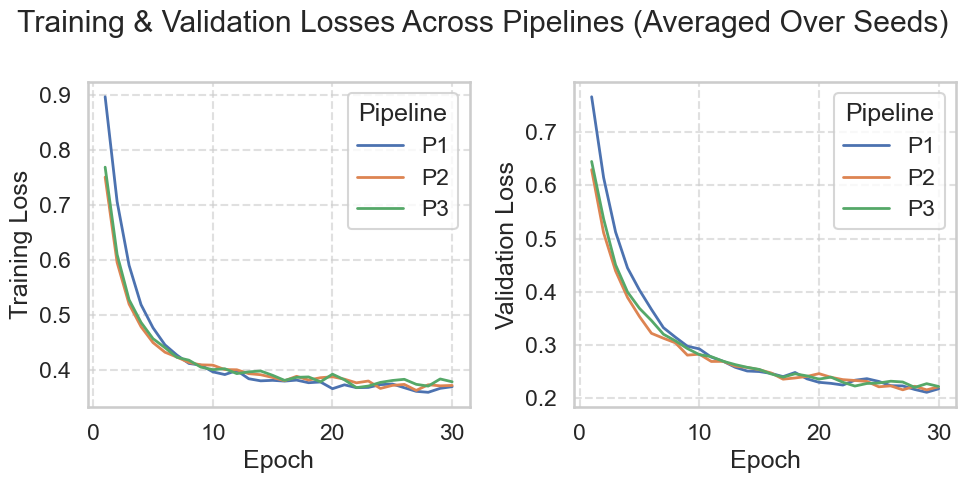

In [30]:
history_cvs = "results/pipeline ablation/all_pipelines_history.csv"
figurename = "Allpipelines_TrainVal_loss"
plot_loss_summary(history_cvs,figurename)

Plan
========
Optimizing Baseline U-Net Setup (Model development) using P2 as selected pipeline:
- We first train the base model again on P2 for 50 epochs
- Then Train the optimized model on P2 also for 50 epochs
- Compare performace (Total training time?, Average epoch time?, GPU usage? ) and segmentation results (Train and Val losses, Dice (WT, TC, ET), HD95)
- Adjust the optimized model and train again.
- adjust the training config to see results.

In [27]:
##Training Config! 


# --- CONFIG ---
epochs   = 50         # smoke test = 1, full ablation = 50
early_stopping = True
es_patience = 10         # full ablation = 10
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seeds for reproducibility
seeds = [5] #[0, 1, 2]   # smoke test = [42], full ablation = [0,1,2]

pipelines={
        # "P1": (train_loader_P1, val_loader_P1),
        "P2": (train_loader_P2, val_loader_P2)
        # "P3": (train_loader_P3, val_loader_P3),
    }

# define builders
model_base   = lambda: UNet3D(in_ch=4, out_ch=4) #base model
model_optimized  = lambda: UNet3D_Optimized(in_ch=4, out_ch=4,dropout= 0.2,deep_supervision = True ) #optimized model
loss_fn_fn    = DiceCELoss
optimizer_fn  = lambda model: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler_fn  = lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(
                    opt, mode="min", factor=0.5, patience=5, min_lr=1e-6
)



Training base Model on P2 
=

In [43]:
##Training base Model on P2 

print("=================================Evaluating Base Model by Training on P2=================================")
df_hist_base, df_summary_base = run_train_eval(
    seeds=seeds,
    pipelines=pipelines,
    model_fn=model_base,
    loss_fn_fn=loss_fn_fn,
    optimizer_fn=optimizer_fn,
    modelName = "BaseModel",
    scheduler_fn=scheduler_fn,
    early_stopping = early_stopping,
    epochs=epochs,
    patience=es_patience,
    lr=lr,
    device=device,
    results_dir="results/model comparison/base"
    
)

# print("=================================Aggregate Result for Base Model on P2=================================")
# print(df_hist_base, df_summary_base)

=================================Evaluating Base Model by Training on P2=================================

=== Seed 5 ===
Global seed set to 5

--- Pipeline P2 ---

=== Training UNet on P2_s5 ===


[ Val ] Epoch 1/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.86it/s]


Epoch 1/50  train_loss=0.8221  val_loss=0.6917  val_dice=0.4112


[ Val ] Epoch 2/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 2/50  train_loss=0.6522  val_loss=0.5690  val_dice=0.4159


[ Val ] Epoch 3/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 3/50  train_loss=0.5563  val_loss=0.4921  val_dice=0.4785


[ Val ] Epoch 4/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.86it/s]


Epoch 4/50  train_loss=0.4994  val_loss=0.4112  val_dice=0.5880


[ Val ] Epoch 5/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.75it/s]


Epoch 5/50  train_loss=0.4609  val_loss=0.3782  val_dice=0.6014


[ Val ] Epoch 6/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 6/50  train_loss=0.4505  val_loss=0.3575  val_dice=0.6081


[ Val ] Epoch 7/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 7/50  train_loss=0.4307  val_loss=0.3218  val_dice=0.6355


[ Val ] Epoch 8/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 8/50  train_loss=0.4229  val_loss=0.3312  val_dice=0.6054


[ Val ] Epoch 9/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 9/50  train_loss=0.3970  val_loss=0.2869  val_dice=0.6467


[ Val ] Epoch 10/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 10/50  train_loss=0.4060  val_loss=0.3158  val_dice=0.5899


[ Val ] Epoch 11/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 11/50  train_loss=0.3974  val_loss=0.2758  val_dice=0.6572


[ Val ] Epoch 12/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.78it/s]


Epoch 12/50  train_loss=0.3978  val_loss=0.2649  val_dice=0.6595


[ Val ] Epoch 13/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 13/50  train_loss=0.3903  val_loss=0.2538  val_dice=0.6660


[ Val ] Epoch 14/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 14/50  train_loss=0.3940  val_loss=0.2653  val_dice=0.6543


[ Val ] Epoch 15/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 15/50  train_loss=0.3974  val_loss=0.2505  val_dice=0.6701


[ Val ] Epoch 16/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 16/50  train_loss=0.4083  val_loss=0.2812  val_dice=0.6482


[ Val ] Epoch 17/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 17/50  train_loss=0.3936  val_loss=0.2421  val_dice=0.6794


[ Val ] Epoch 18/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.95it/s]


Epoch 18/50  train_loss=0.3975  val_loss=0.2470  val_dice=0.6794


[ Val ] Epoch 19/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 19/50  train_loss=0.3784  val_loss=0.2368  val_dice=0.6854


[ Val ] Epoch 20/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 20/50  train_loss=0.3874  val_loss=0.2423  val_dice=0.6804


[ Val ] Epoch 21/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.96it/s]


Epoch 21/50  train_loss=0.3791  val_loss=0.2376  val_dice=0.6956


[ Val ] Epoch 22/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 22/50  train_loss=0.3875  val_loss=0.2380  val_dice=0.6888


[ Val ] Epoch 23/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 23/50  train_loss=0.3795  val_loss=0.2385  val_dice=0.6943


[ Val ] Epoch 24/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 24/50  train_loss=0.3968  val_loss=0.2406  val_dice=0.6871


[ Val ] Epoch 25/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 25/50  train_loss=0.3895  val_loss=0.2397  val_dice=0.6928


[ Val ] Epoch 26/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 26/50  train_loss=0.3628  val_loss=0.2206  val_dice=0.7194


[ Val ] Epoch 27/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 27/50  train_loss=0.3817  val_loss=0.2134  val_dice=0.7216


[ Val ] Epoch 28/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 28/50  train_loss=0.3910  val_loss=0.2288  val_dice=0.7086


[ Val ] Epoch 29/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 29/50  train_loss=0.3725  val_loss=0.2157  val_dice=0.7158


[ Val ] Epoch 30/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.95it/s]


Epoch 30/50  train_loss=0.3756  val_loss=0.2232  val_dice=0.7189


[ Val ] Epoch 31/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 31/50  train_loss=0.3674  val_loss=0.2221  val_dice=0.7236


[ Val ] Epoch 32/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.85it/s]


Epoch 32/50  train_loss=0.3804  val_loss=0.2240  val_dice=0.7084


[ Val ] Epoch 33/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 33/50  train_loss=0.3738  val_loss=0.2118  val_dice=0.7219


[ Val ] Epoch 34/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 34/50  train_loss=0.3721  val_loss=0.2177  val_dice=0.7133


[ Val ] Epoch 35/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 35/50  train_loss=0.3686  val_loss=0.2103  val_dice=0.7227


[ Val ] Epoch 36/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.08it/s]


Epoch 36/50  train_loss=0.3711  val_loss=0.2167  val_dice=0.7154


[ Val ] Epoch 37/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


Epoch 37/50  train_loss=0.3571  val_loss=0.2223  val_dice=0.7198


[ Val ] Epoch 38/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 38/50  train_loss=0.3887  val_loss=0.2209  val_dice=0.7126


[ Val ] Epoch 39/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 39/50  train_loss=0.3638  val_loss=0.2051  val_dice=0.7363


[ Val ] Epoch 40/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 40/50  train_loss=0.3771  val_loss=0.2158  val_dice=0.7278


[ Val ] Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 41/50  train_loss=0.4031  val_loss=0.2284  val_dice=0.7165


[ Val ] Epoch 42/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 42/50  train_loss=0.3589  val_loss=0.2057  val_dice=0.7387


[ Val ] Epoch 43/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.86it/s]


Epoch 43/50  train_loss=0.3667  val_loss=0.2135  val_dice=0.7278


[ Val ] Epoch 44/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.95it/s]


Epoch 44/50  train_loss=0.3743  val_loss=0.2407  val_dice=0.7125


[ Val ] Epoch 45/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 45/50  train_loss=0.3477  val_loss=0.1986  val_dice=0.7311


[ Val ] Epoch 46/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.85it/s]


Epoch 46/50  train_loss=0.3812  val_loss=0.2065  val_dice=0.7305


[ Val ] Epoch 47/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.04it/s]


Epoch 47/50  train_loss=0.3803  val_loss=0.2111  val_dice=0.7336


[ Val ] Epoch 48/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 48/50  train_loss=0.3787  val_loss=0.2118  val_dice=0.7182


[ Val ] Epoch 49/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 49/50  train_loss=0.3512  val_loss=0.2081  val_dice=0.7280


[ Val ] Epoch 50/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]
C:\Projects\CV_final project\UNET_BTS\utils\train_unet.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Epoch 50/50  train_loss=0.3715  val_loss=0.2066  val_dice=0.7255

=== Training Summary ===
Total time: 189.41 min
Avg epoch time: 227.30 s
Peak GPU memory: 2039.09 MB
Saved history → results/model comparison/base\P2_history_5.csv

Saved all histories → results/model comparison/base\all_pipelines_history.csv

=== Final aggregated results ===

Pipeline P2:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.994 ± 0.000
    NonEn   : 0.551 ± 0.000
    Edema   : 0.720 ± 0.000
    Enh     : 0.657 ± 0.000
  Dice (WT, TC, ET):
    WT: 0.867 ± 0.000
    TC: 0.770 ± 0.000
    ET: 0.657 ± 0.000
  HD95 (WT, TC, ET):
    WT: 5.106 ± 0.000
    TC: nan ± nan
    ET: nan ± nan
Saved summary → results/model comparison/base\all_results.csv


Experiment 1: Training Optimized Model 1 on P2 
=
-Code and model overwritten 

Experiment 2: Training Optimized Model 2 on P2 
=

In [20]:
##Experiment 2: Training Optimized Model 2 on P2 
'''
# --- CONFIG ---
epochs   = 50         # smoke test = 1, full ablation = 50
early_stopping = True
es_patience = 10         # full ablation = 10
lr = 1e-4

# define builders
model_optimized  = lambda: UNet3D_Optimized_2(in_ch=4, out_ch=4,dropout= 0.2,deep_supervision = True ) #optimized model
'''

print("=================================Evaluating Optimized Model by Training on P2=================================")
df_hist_opt, df_summary_opt = run_train_eval(
    seeds=seeds,
    pipelines=pipelines,
    model_fn=model_optimized,
    loss_fn_fn=loss_fn_fn,
    optimizer_fn=optimizer_fn,
    modelName = "optModel2",
    scheduler_fn=scheduler_fn,
    early_stopping = early_stopping,
    epochs=epochs,
    patience=es_patience,
    lr=lr,
    device=device,
    results_dir="results/model comparison/optimized"
)

# print("=================================Aggregate Result for optimized Model on P2=================================")
# print(df_hist_opt,df_summary_opt )

=================================Evaluating Optimized Model by Training on P2=================================

=== Seed 5 ===
Global seed set to 5

--- Pipeline P2 ---

=== Training UNet on P2_s5 ===


[ Val ] Epoch 1/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.74it/s]


Epoch 1/50  train_loss=1.0447  val_loss=0.7880  val_dice=0.2640


[ Val ] Epoch 2/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.53it/s]


Epoch 2/50  train_loss=0.8157  val_loss=0.6807  val_dice=0.3535


[ Val ] Epoch 3/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.55it/s]


Epoch 3/50  train_loss=0.7699  val_loss=0.6405  val_dice=0.4037


[ Val ] Epoch 4/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 4/50  train_loss=0.7611  val_loss=0.6081  val_dice=0.5252


[ Val ] Epoch 5/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 5/50  train_loss=0.7483  val_loss=0.5579  val_dice=0.5517


[ Val ] Epoch 6/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 6/50  train_loss=0.7401  val_loss=0.5448  val_dice=0.6217


[ Val ] Epoch 7/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.61it/s]


Epoch 7/50  train_loss=0.7238  val_loss=0.5661  val_dice=0.6055


[ Val ] Epoch 8/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


Epoch 8/50  train_loss=0.7353  val_loss=0.5232  val_dice=0.6477


[ Val ] Epoch 9/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 9/50  train_loss=0.7262  val_loss=0.5326  val_dice=0.6367


[ Val ] Epoch 10/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 10/50  train_loss=0.6798  val_loss=0.4896  val_dice=0.6652


[ Val ] Epoch 11/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 11/50  train_loss=0.7039  val_loss=0.4864  val_dice=0.6595


[ Val ] Epoch 12/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 12/50  train_loss=0.7357  val_loss=0.5082  val_dice=0.6590


[ Val ] Epoch 13/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


Epoch 13/50  train_loss=0.6835  val_loss=0.4750  val_dice=0.6795


[ Val ] Epoch 14/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.61it/s]


Epoch 14/50  train_loss=0.7068  val_loss=0.4737  val_dice=0.6714


[ Val ] Epoch 15/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 15/50  train_loss=0.6964  val_loss=0.4817  val_dice=0.6791


[ Val ] Epoch 16/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 16/50  train_loss=0.7032  val_loss=0.4847  val_dice=0.6835


[ Val ] Epoch 17/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


Epoch 17/50  train_loss=0.7314  val_loss=0.4770  val_dice=0.6837


[ Val ] Epoch 18/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.61it/s]


Epoch 18/50  train_loss=0.7069  val_loss=0.4427  val_dice=0.6891


[ Val ] Epoch 19/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 19/50  train_loss=0.6965  val_loss=0.4479  val_dice=0.6837


[ Val ] Epoch 20/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 20/50  train_loss=0.7013  val_loss=0.4409  val_dice=0.6858


[ Val ] Epoch 21/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 21/50  train_loss=0.6708  val_loss=0.4563  val_dice=0.6844


[ Val ] Epoch 22/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 22/50  train_loss=0.6999  val_loss=0.4473  val_dice=0.6941


[ Val ] Epoch 23/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 23/50  train_loss=0.7143  val_loss=0.4744  val_dice=0.6948


[ Val ] Epoch 24/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 24/50  train_loss=0.6737  val_loss=0.4330  val_dice=0.6909


[ Val ] Epoch 25/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 25/50  train_loss=0.6814  val_loss=0.4178  val_dice=0.7008


[ Val ] Epoch 26/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 26/50  train_loss=0.6859  val_loss=0.4095  val_dice=0.7096


[ Val ] Epoch 27/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 27/50  train_loss=0.6810  val_loss=0.4310  val_dice=0.6979


[ Val ] Epoch 28/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 28/50  train_loss=0.6786  val_loss=0.4213  val_dice=0.6947


[ Val ] Epoch 29/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 29/50  train_loss=0.7016  val_loss=0.4142  val_dice=0.7104


[ Val ] Epoch 30/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 30/50  train_loss=0.6662  val_loss=0.4139  val_dice=0.7081


[ Val ] Epoch 31/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 31/50  train_loss=0.6926  val_loss=0.4739  val_dice=0.6652


[ Val ] Epoch 32/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 32/50  train_loss=0.6846  val_loss=0.4174  val_dice=0.7093


[ Val ] Epoch 33/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 33/50  train_loss=0.7162  val_loss=0.4177  val_dice=0.7145


[ Val ] Epoch 34/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 34/50  train_loss=0.6848  val_loss=0.4052  val_dice=0.7183


[ Val ] Epoch 35/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 35/50  train_loss=0.6644  val_loss=0.3959  val_dice=0.7234


[ Val ] Epoch 36/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 36/50  train_loss=0.6847  val_loss=0.3971  val_dice=0.7249


[ Val ] Epoch 37/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 37/50  train_loss=0.6519  val_loss=0.3882  val_dice=0.7150


[ Val ] Epoch 38/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 38/50  train_loss=0.6807  val_loss=0.4283  val_dice=0.7129


[ Val ] Epoch 39/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 39/50  train_loss=0.6630  val_loss=0.3913  val_dice=0.7248


[ Val ] Epoch 40/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:31<00:00,  2.37it/s]


Epoch 40/50  train_loss=0.6537  val_loss=0.3907  val_dice=0.7223


[ Val ] Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


Epoch 41/50  train_loss=0.6429  val_loss=0.3872  val_dice=0.7278


[ Val ] Epoch 42/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 42/50  train_loss=0.6964  val_loss=0.4169  val_dice=0.7254


[ Val ] Epoch 43/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 43/50  train_loss=0.6566  val_loss=0.3874  val_dice=0.7262


[ Val ] Epoch 44/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 44/50  train_loss=0.6712  val_loss=0.3835  val_dice=0.7279


[ Val ] Epoch 45/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 45/50  train_loss=0.6569  val_loss=0.4040  val_dice=0.7344


[ Val ] Epoch 46/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 46/50  train_loss=0.6432  val_loss=0.3755  val_dice=0.7367


[ Val ] Epoch 47/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]


Epoch 47/50  train_loss=0.6738  val_loss=0.3843  val_dice=0.7239


[ Val ] Epoch 48/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 48/50  train_loss=0.6696  val_loss=0.4023  val_dice=0.7205


[ Val ] Epoch 49/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.46it/s]


Epoch 49/50  train_loss=0.6400  val_loss=0.3727  val_dice=0.7325


[ Val ] Epoch 50/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]
C:\Projects\CV_final project\UNET_BTS\utils\train_unet.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Epoch 50/50  train_loss=0.6667  val_loss=0.3814  val_dice=0.7247

=== Training Summary ===
Total time: 218.51 min
Avg epoch time: 262.21 s
Peak GPU memory: 3621.65 MB
Saved history → results/model comparison/optimized\P2_history_5.csv

Saved all histories → results/model comparison/optimized\all_pipelines_history.csv

=== Final aggregated results ===

Pipeline P2:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.994 ± 0.000
    NonEn   : 0.540 ± 0.000
    Edema   : 0.719 ± 0.000
    Enh     : 0.659 ± 0.000
  Dice (WT, TC, ET):
    WT: 0.872 ± 0.000
    TC: 0.788 ± 0.000
    ET: 0.673 ± 0.000
  HD95 (WT, TC, ET):
    WT: 5.203 ± 0.000
    TC: 7.399 ± 0.000
    ET: nan ± nan
Saved summary → results/model comparison/optimized\all_results.csv


Experiment 3: Training Optimized Model 2 on P2 --> No Dropout.
=
Changes:
    -No dropout

In [19]:
##Experiment 3: Training Optimized Model 2 on P2 --> Turning off dropout 
'''
# --- CONFIG ---
epochs   = 50         # smoke test = 1, full ablation = 50
early_stopping = True
es_patience = 10         # full ablation = 10
lr = 1e-4

# define builders
model_optimized  = lambda: UNet3D_Optimized(in_ch=4, out_ch=4,dropout= 0.2,deep_supervision = True ) #optimized model

---Changes--
-No dropout
'''
dropout= 0

model_optimized  = lambda: UNet3D_Optimized_1(in_ch=4, out_ch=4, base_ch = 32, dropout= dropout,deep_supervision = True ) #optimized model

print("=================================Evaluating Optimized Model by Training on P2=================================")
df_hist_opt, df_summary_opt = run_train_eval(
    seeds=seeds,
    pipelines=pipelines,
    model_fn=model_optimized,
    loss_fn_fn=loss_fn_fn,
    optimizer_fn=optimizer_fn,
    modelName = "optModel2_noDrop",
    scheduler_fn=scheduler_fn,
    early_stopping = early_stopping,
    epochs=epochs,
    patience=es_patience,
    lr=lr,
    device=device,
    results_dir="results/model comparison/optimized"
    
)

# print("=================================Aggregate Result for optimized Model on P2=================================")
# print(df_hist_opt,df_summary_opt )

=================================Evaluating Optimized Model by Training on P2=================================

=== Seed 5 ===
Global seed set to 5

--- Pipeline P2 ---

=== Training UNet on P2_s5 ===


[ Val ] Epoch 1/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.81it/s]


Epoch 1/50  train_loss=1.0109  val_loss=0.7641  val_dice=0.3522


[ Val ] Epoch 2/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 2/50  train_loss=0.8055  val_loss=0.6697  val_dice=0.3601


[ Val ] Epoch 3/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 3/50  train_loss=0.7547  val_loss=0.6032  val_dice=0.5297


[ Val ] Epoch 4/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 4/50  train_loss=0.7377  val_loss=0.6482  val_dice=0.4293


[ Val ] Epoch 5/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.65it/s]


Epoch 5/50  train_loss=0.7224  val_loss=0.5034  val_dice=0.6515


[ Val ] Epoch 6/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 6/50  train_loss=0.7079  val_loss=0.4962  val_dice=0.6478


[ Val ] Epoch 7/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.61it/s]


Epoch 7/50  train_loss=0.6902  val_loss=0.5257  val_dice=0.6209


[ Val ] Epoch 8/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 8/50  train_loss=0.7042  val_loss=0.4843  val_dice=0.6680


[ Val ] Epoch 9/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 9/50  train_loss=0.6969  val_loss=0.4745  val_dice=0.6844


[ Val ] Epoch 10/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.78it/s]


Epoch 10/50  train_loss=0.6376  val_loss=0.4552  val_dice=0.6830


[ Val ] Epoch 11/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


Epoch 11/50  train_loss=0.6718  val_loss=0.4379  val_dice=0.6887


[ Val ] Epoch 12/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.52it/s]


Epoch 12/50  train_loss=0.7118  val_loss=0.4981  val_dice=0.6776


[ Val ] Epoch 13/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.55it/s]


Epoch 13/50  train_loss=0.6546  val_loss=0.4598  val_dice=0.6790


[ Val ] Epoch 14/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]


Epoch 14/50  train_loss=0.6787  val_loss=0.4290  val_dice=0.6998


[ Val ] Epoch 15/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:31<00:00,  2.38it/s]


Epoch 15/50  train_loss=0.6673  val_loss=0.4289  val_dice=0.7082


[ Val ] Epoch 16/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 16/50  train_loss=0.6706  val_loss=0.4905  val_dice=0.7124


[ Val ] Epoch 17/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.51it/s]


Epoch 17/50  train_loss=0.7049  val_loss=0.4344  val_dice=0.6978


[ Val ] Epoch 18/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 18/50  train_loss=0.6774  val_loss=0.3965  val_dice=0.7174


[ Val ] Epoch 19/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.53it/s]


Epoch 19/50  train_loss=0.6590  val_loss=0.3928  val_dice=0.7163


[ Val ] Epoch 20/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.53it/s]


Epoch 20/50  train_loss=0.6678  val_loss=0.3936  val_dice=0.7081


[ Val ] Epoch 21/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


Epoch 21/50  train_loss=0.6296  val_loss=0.4186  val_dice=0.7034


[ Val ] Epoch 22/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:32<00:00,  2.28it/s]


Epoch 22/50  train_loss=0.6650  val_loss=0.3917  val_dice=0.7187


[ Val ] Epoch 23/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.46it/s]


Epoch 23/50  train_loss=0.6813  val_loss=0.4601  val_dice=0.7121


[ Val ] Epoch 24/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 24/50  train_loss=0.6395  val_loss=0.3719  val_dice=0.7194


[ Val ] Epoch 25/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:32<00:00,  2.28it/s]


Epoch 25/50  train_loss=0.6433  val_loss=0.3710  val_dice=0.7164


[ Val ] Epoch 26/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.45it/s]


Epoch 26/50  train_loss=0.6604  val_loss=0.3780  val_dice=0.7193


[ Val ] Epoch 27/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.54it/s]


Epoch 27/50  train_loss=0.6502  val_loss=0.3931  val_dice=0.7234


[ Val ] Epoch 28/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 28/50  train_loss=0.6447  val_loss=0.3718  val_dice=0.7303


[ Val ] Epoch 29/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


Epoch 29/50  train_loss=0.6666  val_loss=0.3756  val_dice=0.7341


[ Val ] Epoch 30/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.40it/s]


Epoch 30/50  train_loss=0.6371  val_loss=0.3939  val_dice=0.7200


[ Val ] Epoch 31/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 31/50  train_loss=0.6619  val_loss=0.3957  val_dice=0.7296


[ Val ] Epoch 32/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 32/50  train_loss=0.6473  val_loss=0.3672  val_dice=0.7367


[ Val ] Epoch 33/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 33/50  train_loss=0.6883  val_loss=0.3798  val_dice=0.7317


[ Val ] Epoch 34/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.67it/s]


Epoch 34/50  train_loss=0.6545  val_loss=0.3814  val_dice=0.7412


[ Val ] Epoch 35/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 35/50  train_loss=0.6369  val_loss=0.3589  val_dice=0.7455


[ Val ] Epoch 36/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.51it/s]


Epoch 36/50  train_loss=0.6540  val_loss=0.3598  val_dice=0.7452


[ Val ] Epoch 37/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:32<00:00,  2.27it/s]


Epoch 37/50  train_loss=0.6193  val_loss=0.3537  val_dice=0.7369


[ Val ] Epoch 38/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


Epoch 38/50  train_loss=0.6485  val_loss=0.4247  val_dice=0.7220


[ Val ] Epoch 39/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 39/50  train_loss=0.6304  val_loss=0.3711  val_dice=0.7307


[ Val ] Epoch 40/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.46it/s]


Epoch 40/50  train_loss=0.6249  val_loss=0.3523  val_dice=0.7419


[ Val ] Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.55it/s]


Epoch 41/50  train_loss=0.6105  val_loss=0.3598  val_dice=0.7421


[ Val ] Epoch 42/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 42/50  train_loss=0.6640  val_loss=0.4035  val_dice=0.7239


[ Val ] Epoch 43/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.45it/s]


Epoch 43/50  train_loss=0.6204  val_loss=0.3549  val_dice=0.7395


[ Val ] Epoch 44/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.61it/s]


Epoch 44/50  train_loss=0.6406  val_loss=0.3847  val_dice=0.7365


[ Val ] Epoch 45/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 45/50  train_loss=0.6188  val_loss=0.3658  val_dice=0.7415


[ Val ] Epoch 46/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.52it/s]


Epoch 46/50  train_loss=0.6076  val_loss=0.3444  val_dice=0.7493


[ Val ] Epoch 47/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.55it/s]


Epoch 47/50  train_loss=0.6405  val_loss=0.3867  val_dice=0.7248


[ Val ] Epoch 48/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]


Epoch 48/50  train_loss=0.6341  val_loss=0.3628  val_dice=0.7301


[ Val ] Epoch 49/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.72it/s]


Epoch 49/50  train_loss=0.6059  val_loss=0.3361  val_dice=0.7434


[ Val ] Epoch 50/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.59it/s]
C:\Projects\CV_final project\UNET_BTS\utils\train_unet.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Epoch 50/50  train_loss=0.6253  val_loss=0.3434  val_dice=0.7385

=== Training Summary ===
Total time: 218.78 min
Avg epoch time: 262.54 s
Peak GPU memory: 3334.95 MB
Saved history → results/model comparison/optimized\P2_history_5.csv

Saved all histories → results/model comparison/optimized\all_pipelines_history.csv

=== Final aggregated results ===

Pipeline P2:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.994 ± 0.000
    NonEn   : 0.573 ± 0.000
    Edema   : 0.730 ± 0.000
    Enh     : 0.681 ± 0.000
  Dice (WT, TC, ET):
    WT: 0.877 ± 0.000
    TC: 0.806 ± 0.000
    ET: 0.689 ± 0.000
  HD95 (WT, TC, ET):
    WT: 4.624 ± 0.000
    TC: 5.318 ± 0.000
    ET: nan ± nan
Saved summary → results/model comparison/optimized\all_results.csv


Experiment 4: Training Optimized Model 2 on P2 --> Dropout off + class weights in DiceCELoss
=
Changes:
    -No dropout
    -Class weights added

In [33]:
##Experiment 4: Training Optimized Model 2 on P2 --> Adjusting hyperparameters (class weights)
'''
# --- CONFIG ---
epochs   = 50         # smoke test = 1, full ablation = 50
early_stopping = True
es_patience = 10         # full ablation = 10
lr = 1e-4

# define builders
model_optimized  = lambda: UNet3D_Optimized(in_ch=4, out_ch=4,dropout= 0.2,deep_supervision = True ) #optimized model

---Changes--
-No dropout
-Using class weights for loss
'''
dropout= 0

##killed at epoch 24 due to non improvement! --[0.05, 0.15, 0.25, 0.55]
# class_weights = torch.tensor([0.05, 0.15, 0.25, 0.55]).to(device) # Background, Non-enh, Edema Enhancing

#Trying new weights --[0.10, 0.20, 0.30, 0.40]
class_weights = torch.tensor([0.10, 0.20, 0.30, 0.40]).to(device) # Background, Non-enh, Edema Enhancing

loss_fn_fn    = lambda : DiceCELoss(class_weights) ##Experiment
model_optimized  = lambda: UNet3D_Optimized_2(in_ch=4, out_ch=4, base_ch = 32, dropout= dropout,deep_supervision = True ) #optimized model

print("=================================Evaluating Optimized Model by Training on P2=================================")
df_hist_opt, df_summary_opt = run_train_eval(
    seeds=seeds,
    pipelines=pipelines,
    model_fn=model_optimized,
    loss_fn_fn=loss_fn_fn,
    optimizer_fn=optimizer_fn,
    modelName = "optModel1_classweight",
    scheduler_fn=scheduler_fn,
    early_stopping = early_stopping,
    epochs=epochs,
    patience=es_patience,
    lr=lr,
    device=device,
    results_dir="results/model comparison/optimized"
)


=================================Evaluating Optimized Model by Training on P2=================================

=== Seed 5 ===
Global seed set to 5

--- Pipeline P2 ---

=== Training UNet on P2_s5 ===


[ Val ] Epoch 1/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 1/50  train_loss=1.1460  val_loss=0.8910  val_dice=0.3620


[ Val ] Epoch 2/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch 2/50  train_loss=0.9847  val_loss=0.8064  val_dice=0.4009


[ Val ] Epoch 3/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.74it/s]


Epoch 3/50  train_loss=0.9164  val_loss=0.6976  val_dice=0.5552


[ Val ] Epoch 4/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 4/50  train_loss=0.9038  val_loss=0.7233  val_dice=0.5794


[ Val ] Epoch 5/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.75it/s]


Epoch 5/50  train_loss=0.8898  val_loss=0.6036  val_dice=0.6476


[ Val ] Epoch 6/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.72it/s]


Epoch 6/50  train_loss=0.8796  val_loss=0.5860  val_dice=0.6656


[ Val ] Epoch 7/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.74it/s]


Epoch 7/50  train_loss=0.8560  val_loss=0.6025  val_dice=0.6552


[ Val ] Epoch 8/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.74it/s]


Epoch 8/50  train_loss=0.8767  val_loss=0.5720  val_dice=0.6846


[ Val ] Epoch 9/50: 100%|██████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


Epoch 9/50  train_loss=0.8622  val_loss=0.5749  val_dice=0.6906


[ Val ] Epoch 10/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 10/50  train_loss=0.7911  val_loss=0.5411  val_dice=0.6964


[ Val ] Epoch 11/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.75it/s]


Epoch 11/50  train_loss=0.8383  val_loss=0.5282  val_dice=0.6936


[ Val ] Epoch 12/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 12/50  train_loss=0.8841  val_loss=0.6087  val_dice=0.6814


[ Val ] Epoch 13/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 13/50  train_loss=0.8110  val_loss=0.5451  val_dice=0.7056


[ Val ] Epoch 14/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:32<00:00,  2.28it/s]


Epoch 14/50  train_loss=0.8505  val_loss=0.5178  val_dice=0.7148


[ Val ] Epoch 15/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.50it/s]


Epoch 15/50  train_loss=0.8317  val_loss=0.5440  val_dice=0.7162


[ Val ] Epoch 16/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.43it/s]


Epoch 16/50  train_loss=0.8369  val_loss=0.5787  val_dice=0.7172


[ Val ] Epoch 17/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.64it/s]


Epoch 17/50  train_loss=0.8793  val_loss=0.5505  val_dice=0.7117


[ Val ] Epoch 18/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 18/50  train_loss=0.8454  val_loss=0.4872  val_dice=0.7197


[ Val ] Epoch 19/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.62it/s]


Epoch 19/50  train_loss=0.8250  val_loss=0.4778  val_dice=0.7267


[ Val ] Epoch 20/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.62it/s]


Epoch 20/50  train_loss=0.8387  val_loss=0.4954  val_dice=0.7110


[ Val ] Epoch 21/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.65it/s]


Epoch 21/50  train_loss=0.7895  val_loss=0.5517  val_dice=0.7061


[ Val ] Epoch 22/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.65it/s]


Epoch 22/50  train_loss=0.8372  val_loss=0.5113  val_dice=0.7132


[ Val ] Epoch 23/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch 23/50  train_loss=0.8591  val_loss=0.6273  val_dice=0.7140


[ Val ] Epoch 24/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.66it/s]


Epoch 24/50  train_loss=0.8041  val_loss=0.4506  val_dice=0.7242


[ Val ] Epoch 25/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 25/50  train_loss=0.8093  val_loss=0.4518  val_dice=0.7213


[ Val ] Epoch 26/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.64it/s]


Epoch 26/50  train_loss=0.8233  val_loss=0.4688  val_dice=0.7272


[ Val ] Epoch 27/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]


Epoch 27/50  train_loss=0.8113  val_loss=0.5026  val_dice=0.7352


[ Val ] Epoch 28/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.66it/s]


Epoch 28/50  train_loss=0.8100  val_loss=0.4667  val_dice=0.7341


[ Val ] Epoch 29/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.72it/s]


Epoch 29/50  train_loss=0.8323  val_loss=0.4712  val_dice=0.7465


[ Val ] Epoch 30/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.62it/s]


Epoch 30/50  train_loss=0.7962  val_loss=0.4777  val_dice=0.7368


[ Val ] Epoch 31/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


Epoch 31/50  train_loss=0.8140  val_loss=0.5422  val_dice=0.7327


[ Val ] Epoch 32/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.51it/s]


Epoch 32/50  train_loss=0.8053  val_loss=0.4468  val_dice=0.7435


[ Val ] Epoch 33/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.57it/s]


Epoch 33/50  train_loss=0.8559  val_loss=0.4872  val_dice=0.7304


[ Val ] Epoch 34/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.48it/s]


Epoch 34/50  train_loss=0.8151  val_loss=0.5169  val_dice=0.7455


[ Val ] Epoch 35/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.42it/s]


Epoch 35/50  train_loss=0.7882  val_loss=0.4587  val_dice=0.7415


[ Val ] Epoch 36/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 36/50  train_loss=0.8064  val_loss=0.4610  val_dice=0.7426


[ Val ] Epoch 37/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.67it/s]


Epoch 37/50  train_loss=0.7689  val_loss=0.4456  val_dice=0.7319


[ Val ] Epoch 38/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.53it/s]


Epoch 38/50  train_loss=0.8015  val_loss=0.5080  val_dice=0.7286


[ Val ] Epoch 39/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.52it/s]


Epoch 39/50  train_loss=0.7749  val_loss=0.4896  val_dice=0.7080


[ Val ] Epoch 40/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.50it/s]


Epoch 40/50  train_loss=0.7695  val_loss=0.4212  val_dice=0.7457


[ Val ] Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.54it/s]


Epoch 41/50  train_loss=0.7487  val_loss=0.4285  val_dice=0.7477


[ Val ] Epoch 42/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.49it/s]


Epoch 42/50  train_loss=0.8124  val_loss=0.4809  val_dice=0.7316


[ Val ] Epoch 43/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch 43/50  train_loss=0.7599  val_loss=0.4329  val_dice=0.7394


[ Val ] Epoch 44/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch 44/50  train_loss=0.7793  val_loss=0.4358  val_dice=0.7374


[ Val ] Epoch 45/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 45/50  train_loss=0.7429  val_loss=0.4597  val_dice=0.7189


[ Val ] Epoch 46/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 46/50  train_loss=0.7225  val_loss=0.3882  val_dice=0.7464


[ Val ] Epoch 47/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 47/50  train_loss=0.7735  val_loss=0.4197  val_dice=0.7404


[ Val ] Epoch 48/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch 48/50  train_loss=0.7532  val_loss=0.4132  val_dice=0.7438


[ Val ] Epoch 49/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:31<00:00,  2.31it/s]


Epoch 49/50  train_loss=0.7370  val_loss=0.3889  val_dice=0.7445


[ Val ] Epoch 50/50: 100%|█████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]
C:\Projects\CV_final project\UNET_BTS\utils\train_unet.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Epoch 50/50  train_loss=0.7560  val_loss=0.4025  val_dice=0.7367

=== Training Summary ===
Total time: 217.22 min
Avg epoch time: 260.67 s
Peak GPU memory: 3521.20 MB
Saved history → results/model comparison/optimized\P2_history_5.csv

Saved all histories → results/model comparison/optimized\optModel1_classweight_all_pipelines_history.csv

=== Final aggregated results ===

Pipeline P2:
  Per-class Dice (BG, NonEn, Edema, Enh):
    BG      : 0.994 ± 0.000
    NonEn   : 0.571 ± 0.000
    Edema   : 0.732 ± 0.000
    Enh     : 0.699 ± 0.000
  Dice (WT, TC, ET):
    WT: 0.880 ± 0.000
    TC: 0.812 ± 0.000
    ET: 0.691 ± 0.000
  HD95 (WT, TC, ET):
    WT: 5.013 ± 0.000
    TC: 5.265 ± 0.000
    ET: nan ± nan
Saved summary → results/model comparison/optimized\optModel1_classweight_results.csv


Comparison & Visualization of Trends of the different models: Train Loss, Val Loss, Val Dice
=

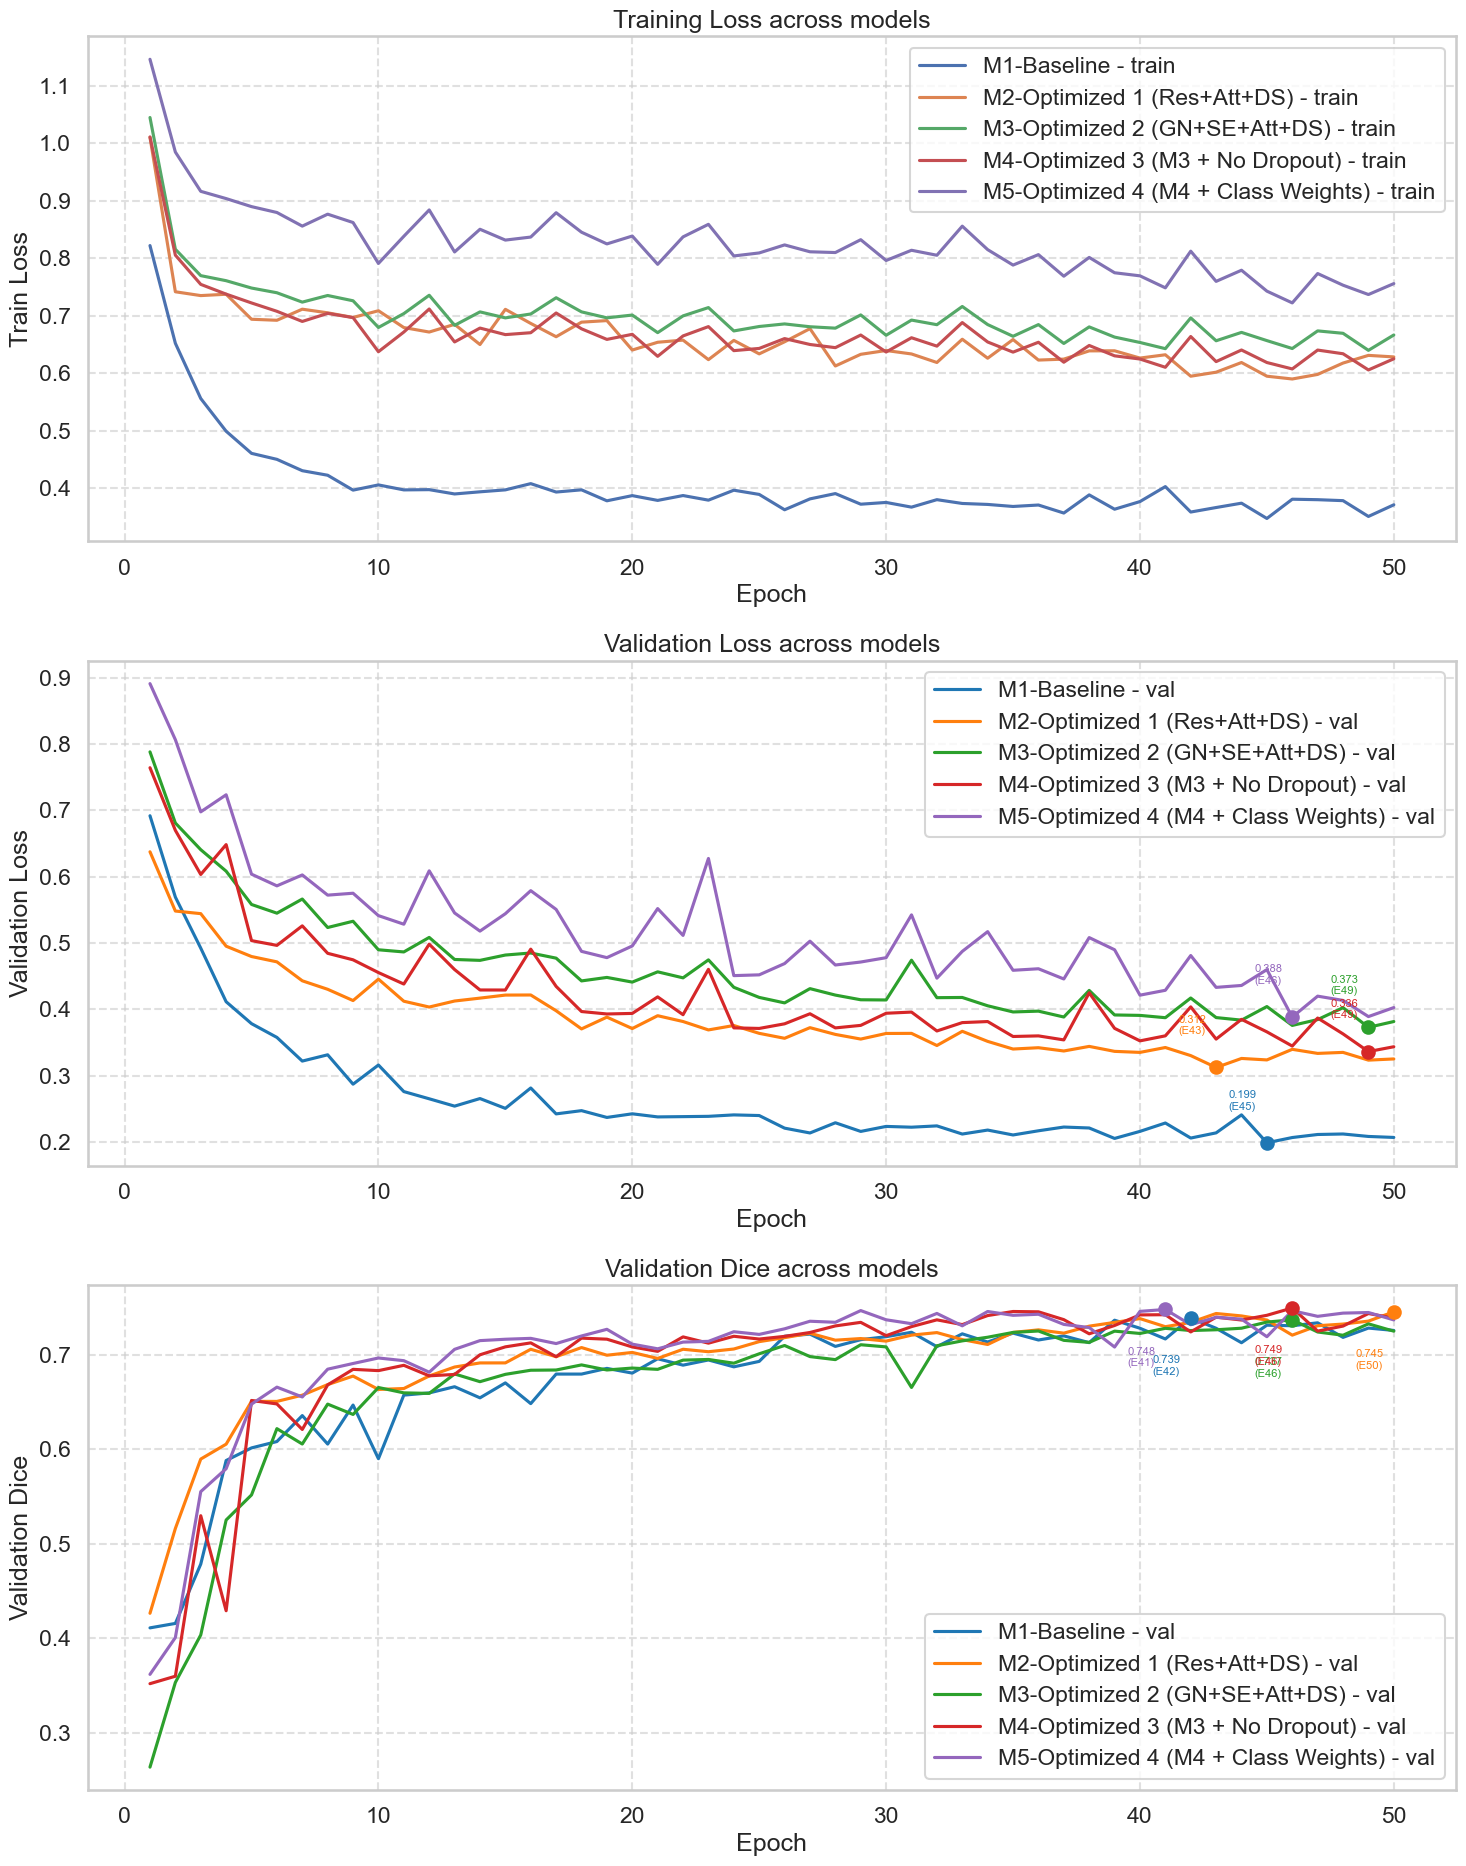

In [3]:
###Comparing models: Train loss, Val Loss, Val Dice

csv_files = [
    "results/model comparison/base/all_pipelines_history.csv",       # M1
    "results/model comparison/optimized/model1/Model_1_history.csv", # M2
    "results/model comparison/optimized/model2/Model_2_history.csv", # M3
    "results/model comparison/optimized/model2_Nodropout/Model_2_Nodropout_history.csv", # M4
    "results/model comparison/optimized/model2_Nodropout_classWeights/Model2_classweight_history.csv" # M5
    
]

labels = [
    "M1-Baseline", 
    "M2-Optimized 1 (Res+Att+DS)", 
    "M3-Optimized 2 (GN+SE+Att+DS)", 
    "M4-Optimized 3 (M3 + No Dropout)",
    "M5-Optimized 4 (M4 + Class Weights)"
]

savepath = "results/Images/ModelComparison.png"

plot_model_comparison(csv_files, labels, savepath)


Best Architecture summary
=

In [24]:
from torchsummary import summary
best_model = UNet3D_Optimized_2(in_ch=4, out_ch=4, base_ch = 32, dropout= 0,deep_supervision = True )
summary(model, input_size=(4, 96, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 96, 96, 96]             128
            Conv3d-2       [-1, 32, 96, 96, 96]           3,456
         GroupNorm-3       [-1, 32, 96, 96, 96]              64
         LeakyReLU-4       [-1, 32, 96, 96, 96]               0
         Dropout3d-5       [-1, 32, 96, 96, 96]               0
            Conv3d-6       [-1, 32, 96, 96, 96]          27,648
         GroupNorm-7       [-1, 32, 96, 96, 96]              64
         LeakyReLU-8       [-1, 32, 96, 96, 96]               0
         Dropout3d-9       [-1, 32, 96, 96, 96]               0
        LeakyReLU-10       [-1, 32, 96, 96, 96]               0
           Conv3d-11           [-1, 2, 1, 1, 1]              66
             ReLU-12           [-1, 2, 1, 1, 1]               0
           Conv3d-13          [-1, 32, 1, 1, 1]              96
          Sigmoid-14          [-1, 32, 

Prediction Visualization using Best Model (M5) and Optimized 3DUnet architechture
=

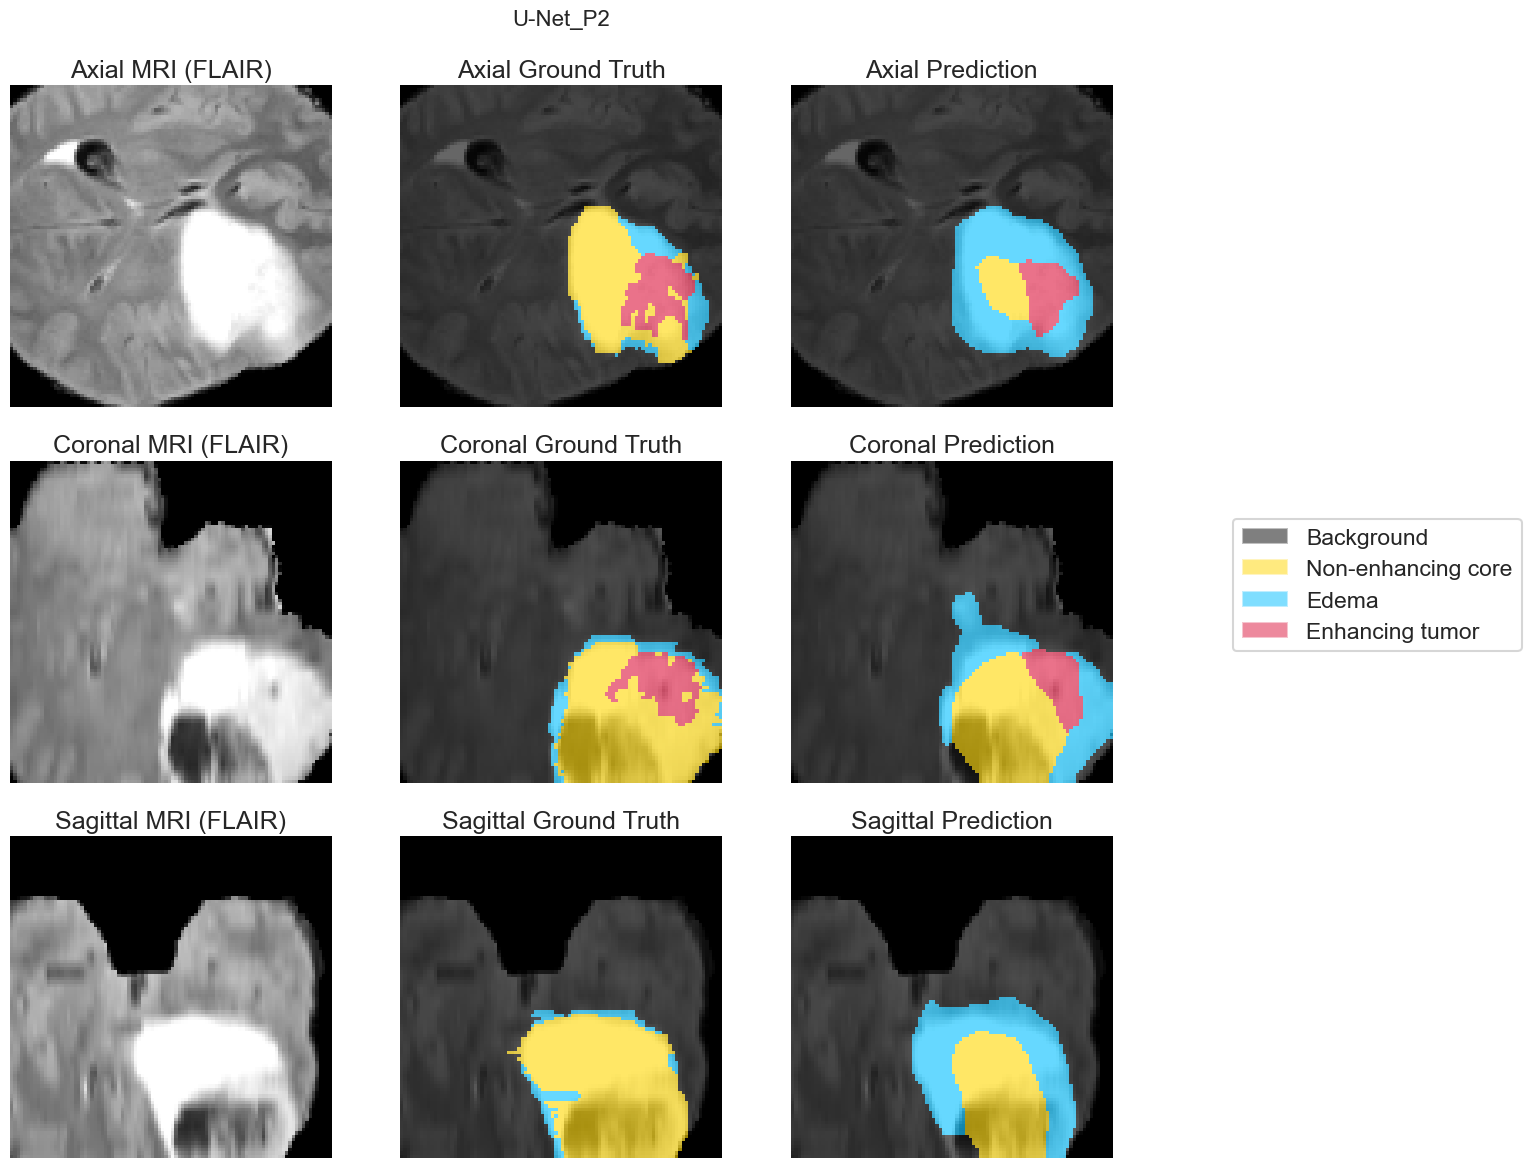

 Figure saved to results/sample_predictions/U-Net_P2.png


In [17]:
batch_size = 1
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cache directories
cache_root = "data/processed/cache"
cache_val   = os.path.join(cache_root, "val")

#==========Data Loading===========================================
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

val_loader_P2 = DataLoader(
    val_dataset_P2, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

# ======================================

best_ckpt = "models/model comparison/optModel1_classweight_P2_s5.pth"
sd= torch.load(best_ckpt ,map_location=device,weights_only=False)
# =======================================




model  = UNet3D_Optimized_2(in_ch=4, out_ch=4, base_ch = 32, dropout= 0,deep_supervision = True ) #optimized model

model.load_state_dict(sd)
model.to(device)

val_loader = val_loader_P2
    
visualize_prediction_multiview(
    model=model, 
    val_loader=val_loader, #pipeline dataset after preprocessing 
    device=device,
    title="U-Net_P2"
    
)

-----ignore------------
=

In [ ]:
# ##Testing Evaluation
# ckpt =  "models/unet_P2_opt_s42.pth"
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seed = 42
# # # fresh model & optimizer per seed
# model = UNet3D_optimized(
#     in_ch=4,
#     out_ch=4,
#     dropout=0.1
#     ).to(device)

# results = eval_experiment(model, val_loader_P2, ckpt, f"P2_s{seed}", device)